In [1]:
!pip install prophet

In [2]:
# Gerekli kütüphaneleri import ediyorum
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import folium
from folium.plugins import MarkerCluster, HeatMap
from IPython.display import IFrame
from prophet import Prophet
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr

import warnings
warnings.filterwarnings("ignore")

In [3]:
# Veri setini yüklüyorum
df = pd.read_csv('/kaggle/input/world-population-by-country-2024/World Population by country 2024.csv')

In [4]:
# İlk bir kaç satırı görüntülüyorum
print("İlk birkaç satır:")
df.head()

İlk birkaç satır:


,Country,Population 2024,Population 2023,Area (km2),Density (/km2),Growth Rate,World %,World Rank
0,India,1441719852,1428627663,3M,485.0,0.0092,0.1801,1
1,China,1425178782,1425671352,9.4M,151.0,-0.0003,0.1780,2
2,United States,341814420,339996563,9.1M,37.0,0.0053,0.0427,3
3,Indonesia,279798049,277534122,1.9M,149.0,0.0082,0.0350,4
4,Pakistan,245209815,240485658,770.9K,318.0,0.0196,0.0306,5


In [5]:
# Veri seti hakkında genel bilgi ediniyorum
print("\nVeri setinin genel bilgileri:")
df.info()


Veri setinin genel bilgileri:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 234 entries, 0 to 233
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Country          234 non-null    object 
 1   Population 2024  234 non-null    int64  
 2   Population 2023  234 non-null    int64  
 3   Area (km2)       234 non-null    object 
 4   Density (/km2)   234 non-null    float64
 5   Growth Rate      234 non-null    float64
 6   World %          228 non-null    float64
 7   World Rank       234 non-null    int64  
dtypes: float64(3), int64(3), object(2)
memory usage: 14.8+ KB


In [6]:
# Temel istatistikleri görüntülüyorum
print("\nTemel istatistikler:")
df.describe()


Temel istatistikler:


,Population 2024,Population 2023,Density (/km2),Growth Rate,World %,World Rank
count,2.340000e+02,2.340000e+02,234.000000,234.000000,228.000000,234.000000
mean,3.468862e+07,3.437442e+07,453.788248,0.009200,0.004446,117.500000
std,1.380750e+08,1.373864e+08,1990.163274,0.011371,0.017459,67.694165
min,5.260000e+02,5.180000e+02,0.140000,-0.030900,0.000000,1.000000
25%,4.264565e+05,4.225982e+05,39.500000,0.001925,0.000100,59.250000
50%,5.626359e+06,5.643895e+06,98.500000,0.007950,0.000750,117.500000
75%,2.392272e+07,2.324537e+07,248.250000,0.015675,0.003000,175.750000
max,1.441720e+09,1.428628e+09,21674.000000,0.048300,0.180100,234.000000


In [7]:
# Eksik verileri kontrol ediyorum
print("\nEksik verilerin kontrol edilmesi:")
df.isnull().sum()


Eksik verilerin kontrol edilmesi:


Country            0
Population 2024    0
Population 2023    0
Area (km2)         0
Density (/km2)     0
Growth Rate        0
World %            6
World Rank         0
dtype: int64

In [8]:
# Eksik verilerin ortalama ile dolduruyorum
df['World %'].fillna(df['World %'].mean(), inplace=True)

In [9]:
# Eksik verilerin yeniden kontrol ediyorum
print("\nEksik verilerin doldurulmasından sonra kontrol edilmesi:")
print(df.isnull().sum())


Eksik verilerin doldurulmasından sonra kontrol edilmesi:
Country            0
Population 2024    0
Population 2023    0
Area (km2)         0
Density (/km2)     0
Growth Rate        0
World %            0
World Rank         0
dtype: int64


In [10]:
# Veri türlerini kontrol ediyorum
print("\nVeri türleri:")
df.dtypes


Veri türleri:


Country             object
Population 2024      int64
Population 2023      int64
Area (km2)          object
Density (/km2)     float64
Growth Rate        float64
World %            float64
World Rank           int64
dtype: object

In [11]:
# Ülkelerin toplam sayısını inceliyorum
print("\nToplam ülke sayısı:")
df['Country'].nunique()


Toplam ülke sayısı:


234

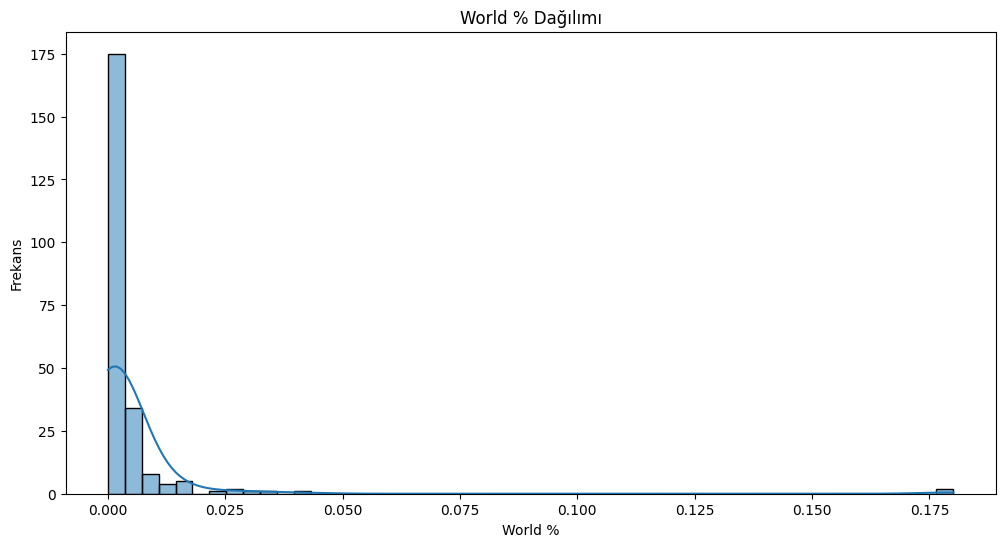

In [12]:
# 'World %' sütununu görselleştiriyorum
plt.figure(figsize=(12, 6))
sns.histplot(df['World %'], bins=50, kde=True)
plt.title('World % Dağılımı')
plt.xlabel('World %')
plt.ylabel('Frekans')
plt.show()

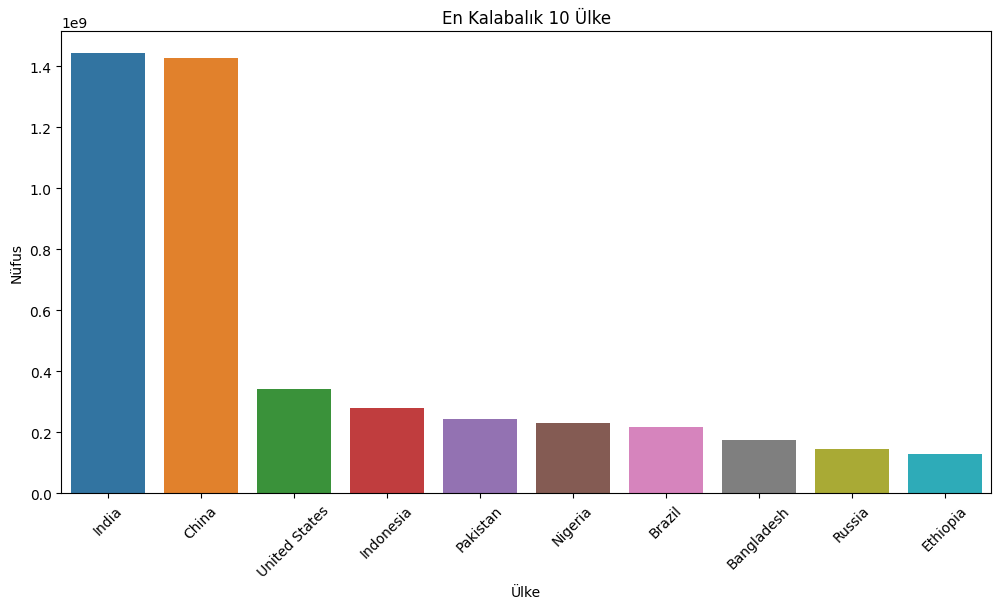

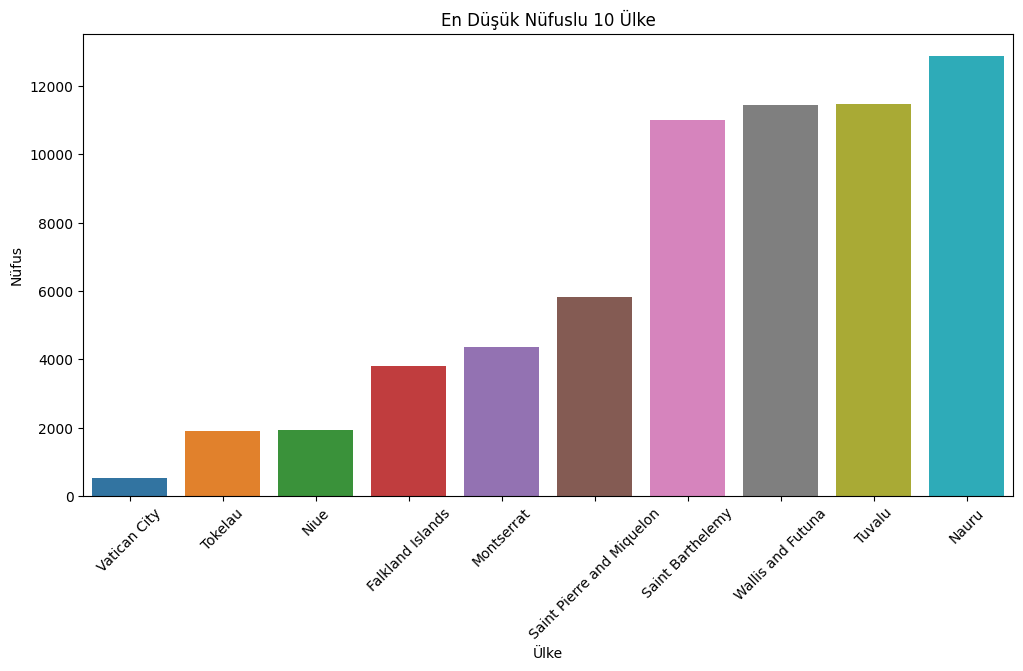

In [13]:
# En kalabalık 10 ülkeyi görselleştiriyorum
top_10_populous_countries = df.nlargest(10, 'Population 2024')
plt.figure(figsize=(12, 6))
sns.barplot(x='Country', y='Population 2024', data=top_10_populous_countries)
plt.title('En Kalabalık 10 Ülke')
plt.xlabel('Ülke')
plt.ylabel('Nüfus')
plt.xticks(rotation=45)
plt.show()

# En düşük nüfuslu 10 ülkeyi görselleştiriyorum
bottom_10_populous_countries = df.nsmallest(10, 'Population 2024')
plt.figure(figsize=(12, 6))
sns.barplot(x='Country', y='Population 2024', data=bottom_10_populous_countries)
plt.title('En Düşük Nüfuslu 10 Ülke')
plt.xlabel('Ülke')
plt.ylabel('Nüfus')
plt.xticks(rotation=45)
plt.show()

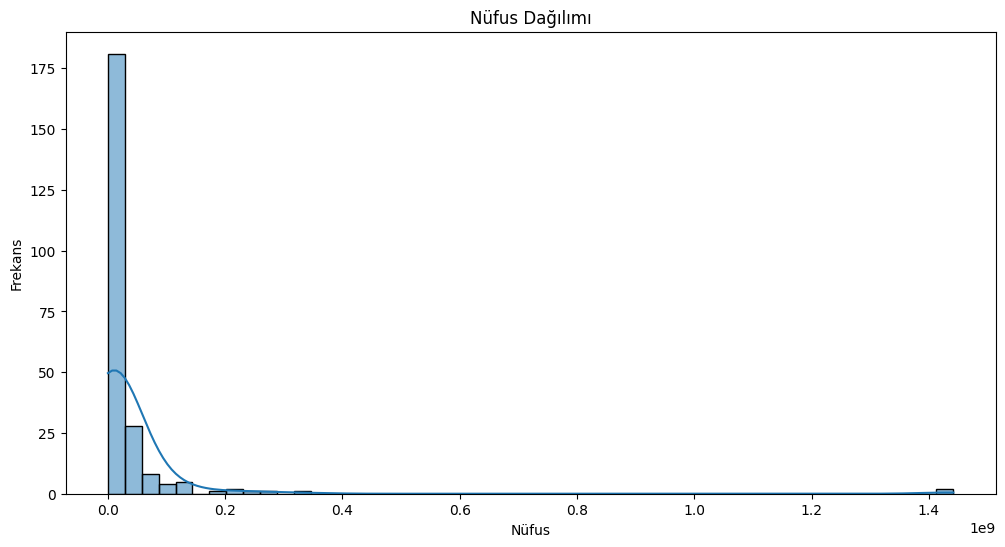

In [14]:
# Nüfus dağılımını görselleştiriyorum
plt.figure(figsize=(12, 6))
sns.histplot(df['Population 2024'], bins=50, kde=True)
plt.title('Nüfus Dağılımı')
plt.xlabel('Nüfus')
plt.ylabel('Frekans')
plt.show()

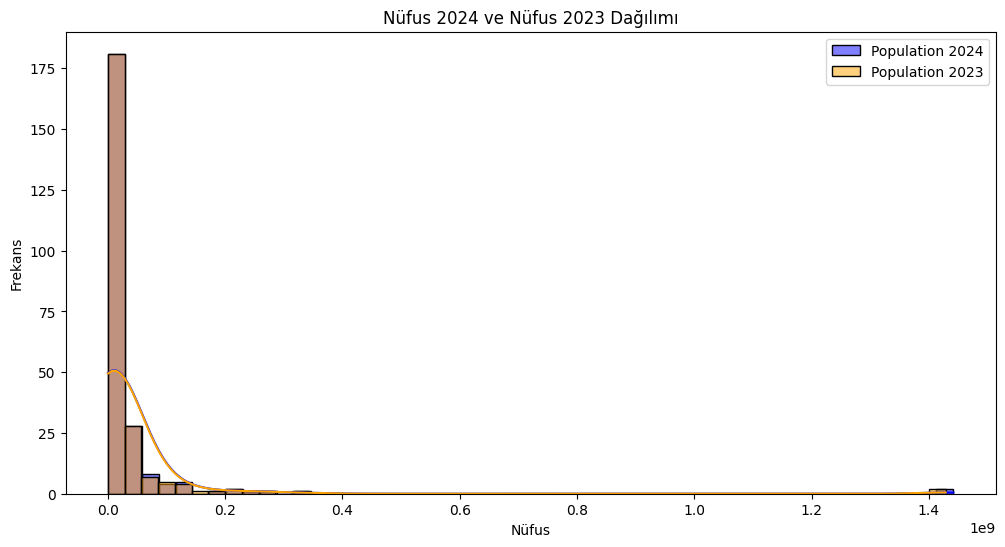

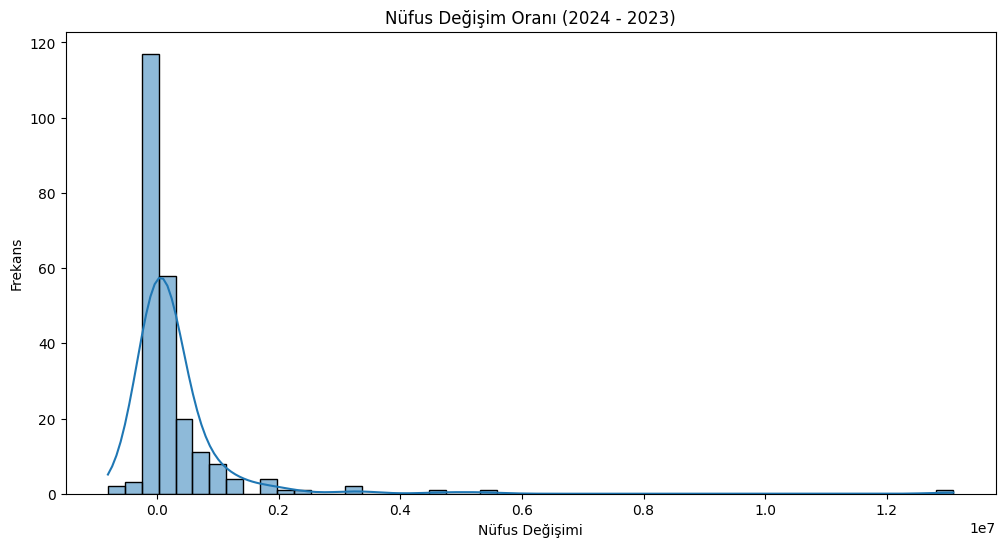

In [15]:
# Nüfus 2024 ve Nüfus 2023 dağılımını görselleştiriyorum
plt.figure(figsize=(12, 6))
sns.histplot(df['Population 2024'], bins=50, kde=True, label='Population 2024', color='blue')
sns.histplot(df['Population 2023'], bins=50, kde=True, label='Population 2023', color='orange')
plt.title('Nüfus 2024 ve Nüfus 2023 Dağılımı')
plt.xlabel('Nüfus')
plt.ylabel('Frekans')
plt.legend()
plt.show()

# Nüfus değişim oranı (2024 - 2023)
df['Population Change'] = df['Population 2024'] - df['Population 2023']
plt.figure(figsize=(12, 6))
sns.histplot(df['Population Change'], bins=50, kde=True)
plt.title('Nüfus Değişim Oranı (2024 - 2023)')
plt.xlabel('Nüfus Değişimi')
plt.ylabel('Frekans')
plt.show()

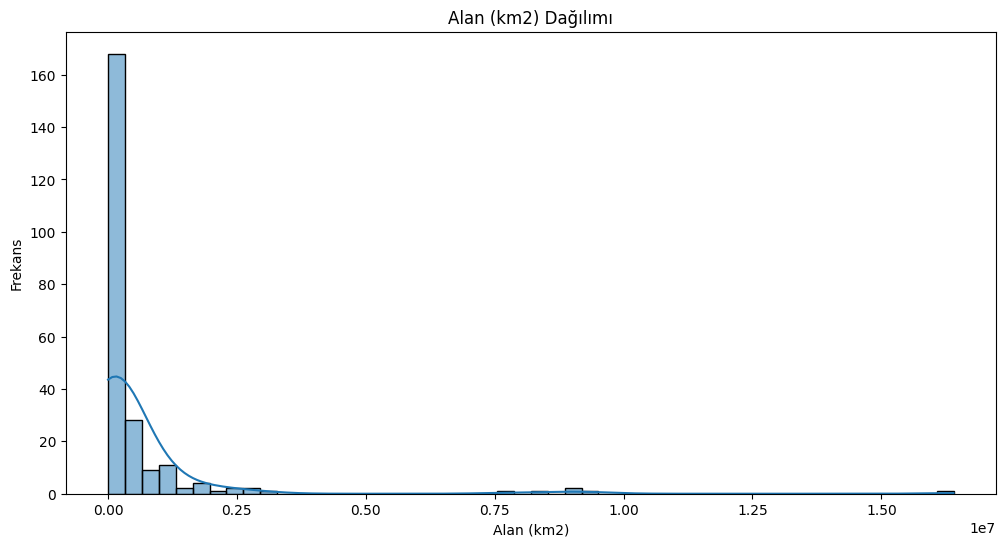

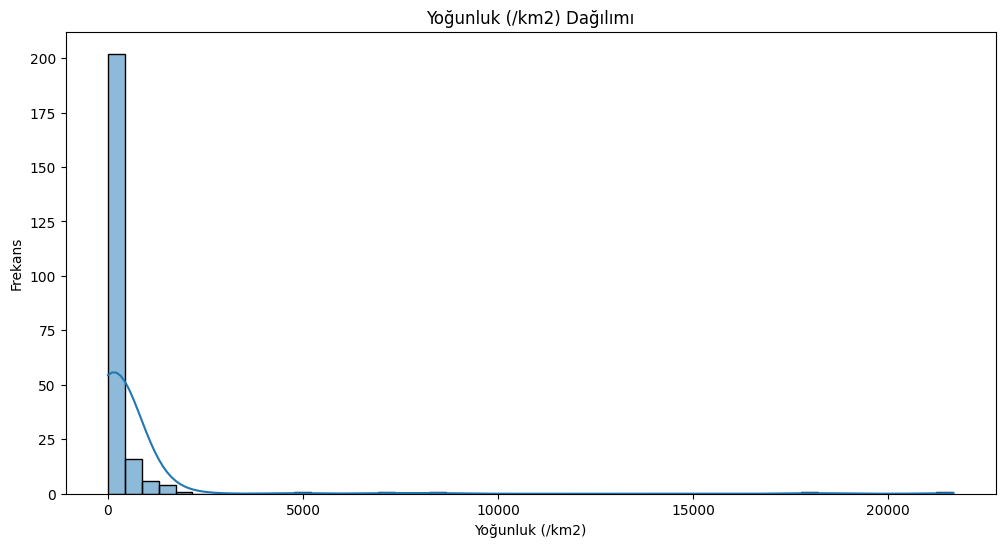

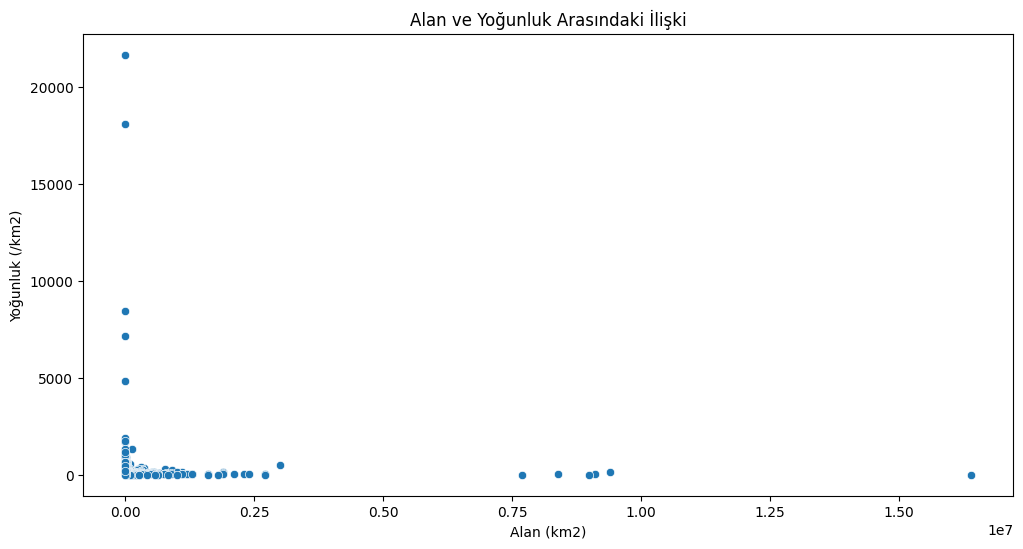

In [16]:
# Alan (km2) sütunundaki verileri sayısal hale getiriyorum
def convert_area(area):
    area = area.strip()
    if '<' in area:
        return 1.0  # '< 1' gibi değerler için 1.0 olarak kabul edelim
    elif 'M' in area:
        return float(area.replace('M', '').replace(',', '').strip()) * 1e6
    elif 'K' in area:
        return float(area.replace('K', '').replace(',', '').strip()) * 1e3
    else:
        return float(area.replace(',', '').strip())

df['Area (km2)'] = df['Area (km2)'].apply(convert_area)

# Alan (km2) dağılımı
plt.figure(figsize=(12, 6))
sns.histplot(df['Area (km2)'], bins=50, kde=True)
plt.title('Alan (km2) Dağılımı')
plt.xlabel('Alan (km2)')
plt.ylabel('Frekans')
plt.show()

# Yoğunluk (/km2) dağılımı
plt.figure(figsize=(12, 6))
sns.histplot(df['Density (/km2)'], bins=50, kde=True)
plt.title('Yoğunluk (/km2) Dağılımı')
plt.xlabel('Yoğunluk (/km2)')
plt.ylabel('Frekans')
plt.show()

# Alan ve Yoğunluk arasındaki ilişki
plt.figure(figsize=(12, 6))
sns.scatterplot(x='Area (km2)', y='Density (/km2)', data=df)
plt.title('Alan ve Yoğunluk Arasındaki İlişki')
plt.xlabel('Alan (km2)')
plt.ylabel('Yoğunluk (/km2)')
plt.show()

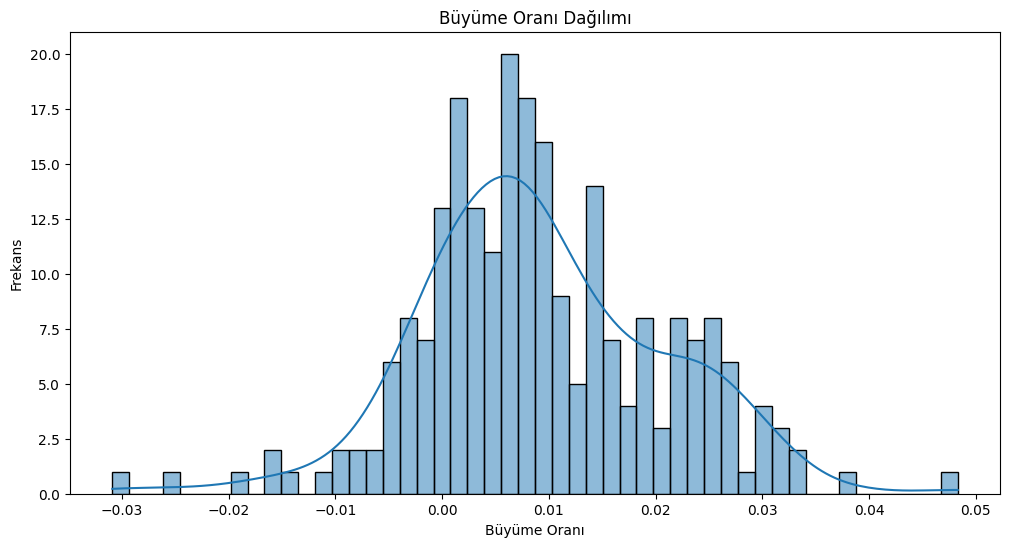

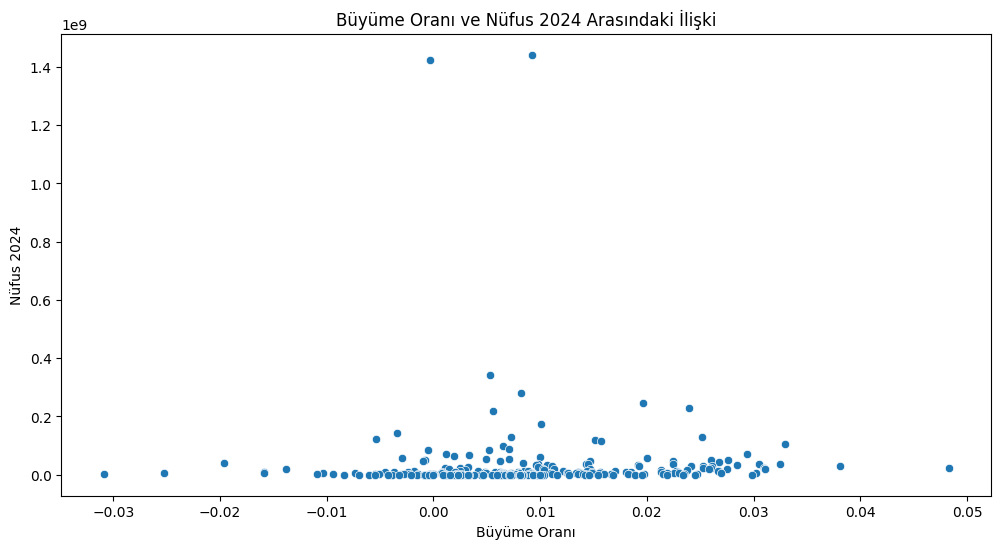

In [17]:
# Büyüme Oranı dağılımı
plt.figure(figsize=(12, 6))
sns.histplot(df['Growth Rate'], bins=50, kde=True)
plt.title('Büyüme Oranı Dağılımı')
plt.xlabel('Büyüme Oranı')
plt.ylabel('Frekans')
plt.show()

# Büyüme Oranı ve Nüfus 2024 arasındaki ilişki
plt.figure(figsize=(12, 6))
sns.scatterplot(x='Growth Rate', y='Population 2024', data=df)
plt.title('Büyüme Oranı ve Nüfus 2024 Arasındaki İlişki')
plt.xlabel('Büyüme Oranı')
plt.ylabel('Nüfus 2024')
plt.show()

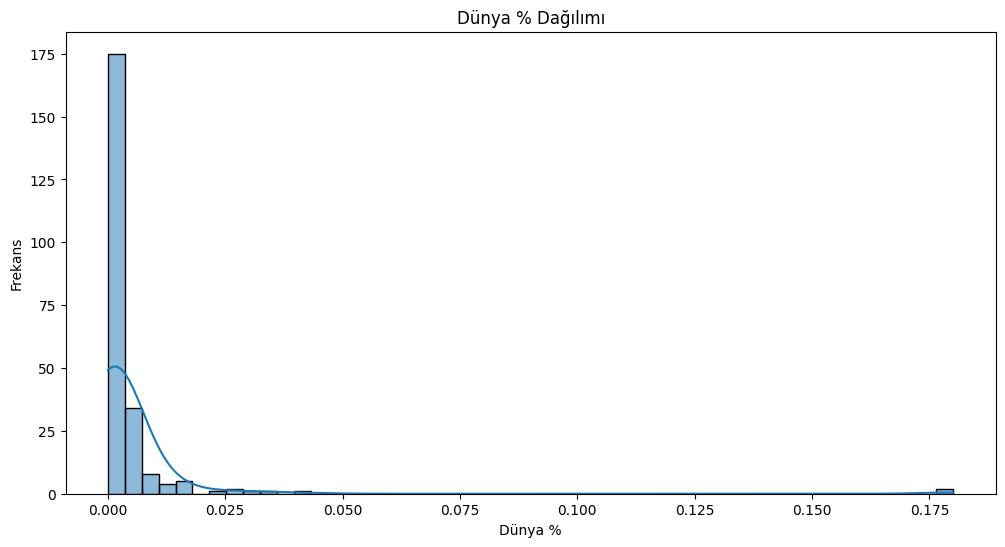

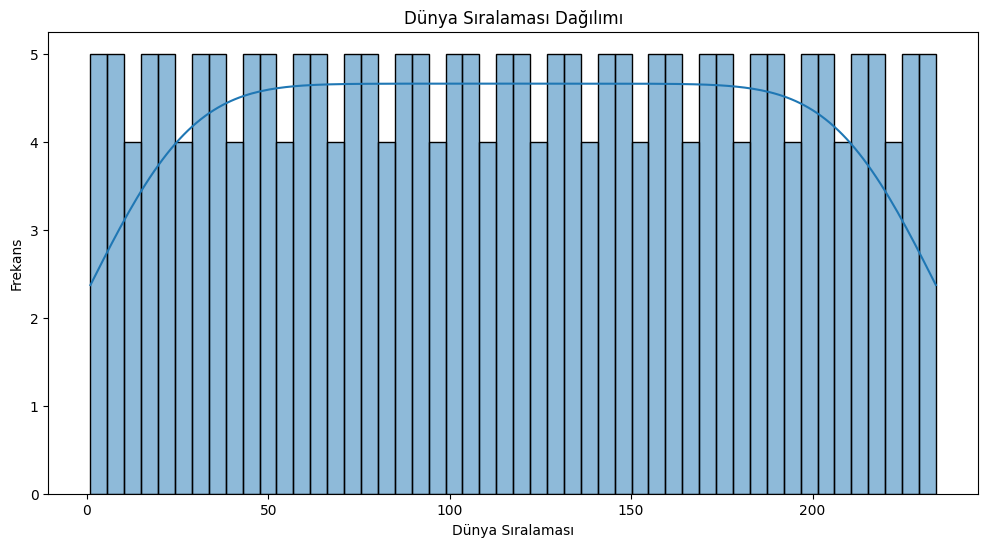

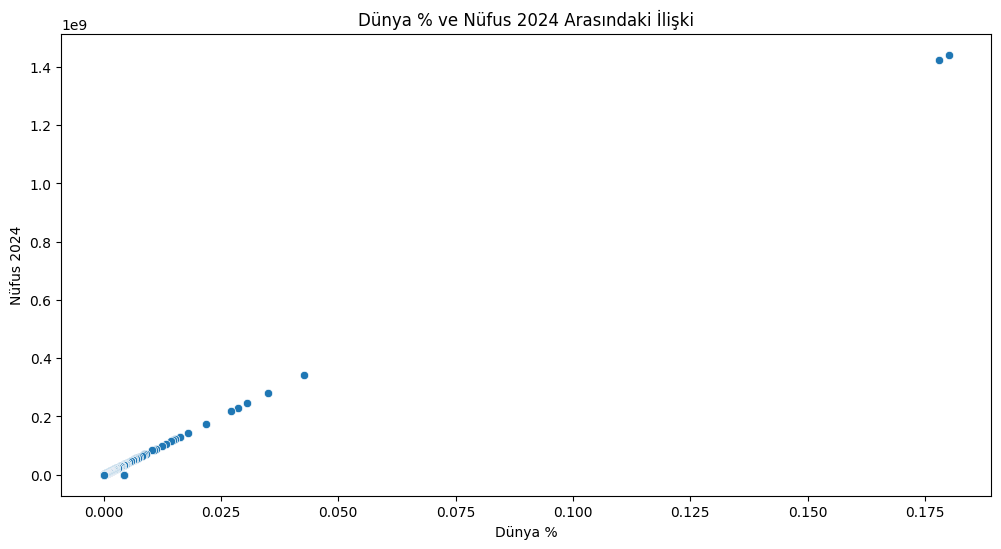

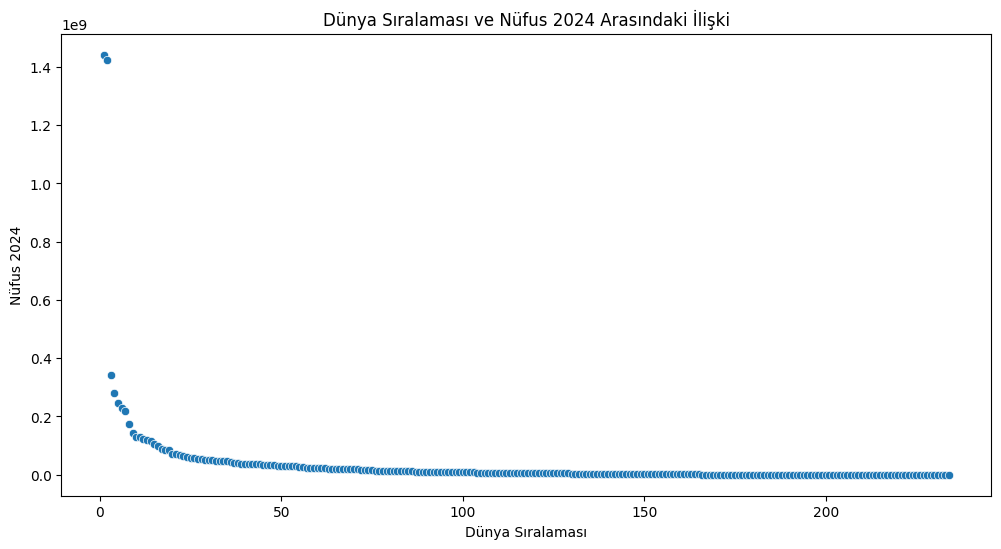

In [18]:
# Dünya % dağılımı
plt.figure(figsize=(12, 6))
sns.histplot(df['World %'], bins=50, kde=True)
plt.title('Dünya % Dağılımı')
plt.xlabel('Dünya %')
plt.ylabel('Frekans')
plt.show()

# Dünya Sıralaması dağılımı
plt.figure(figsize=(12, 6))
sns.histplot(df['World Rank'], bins=50, kde=True)
plt.title('Dünya Sıralaması Dağılımı')
plt.xlabel('Dünya Sıralaması')
plt.ylabel('Frekans')
plt.show()

# Dünya % ve Nüfus 2024 arasındaki ilişki
plt.figure(figsize=(12, 6))
sns.scatterplot(x='World %', y='Population 2024', data=df)
plt.title('Dünya % ve Nüfus 2024 Arasındaki İlişki')
plt.xlabel('Dünya %')
plt.ylabel('Nüfus 2024')
plt.show()

# Dünya Sıralaması ve Nüfus 2024 arasındaki ilişki
plt.figure(figsize=(12, 6))
sns.scatterplot(x='World Rank', y='Population 2024', data=df)
plt.title('Dünya Sıralaması ve Nüfus 2024 Arasındaki İlişki')
plt.xlabel('Dünya Sıralaması')
plt.ylabel('Nüfus 2024')
plt.show()

In [19]:
# Koordinat veri setini yüklüyorum
coords_df = pd.read_csv('/kaggle/input/country-coordinates-world/country-coordinates-world.csv')

In [20]:
# İlk birkaç satırı görüntülüyorum
print(coords_df.head())

    latitude   longitude         Country
0  33.939110   67.709953     Afghanistan
1  41.153332   20.168331         Albania
2  28.033886    1.659626         Algeria
3 -14.270972 -170.132217  American Samoa
4  42.546245    1.601554         Andorra


In [21]:
# Mevcut veri seti ile koordinat veri setini birleştiriyorum
df = df.merge(coords_df, how='left', left_on='Country', right_on='Country')

In [22]:
# Gerekli sütunları seçip ve yeniden adlandırıyorum
df = df[['Country', 'Population 2024', 'Population 2023', 'Area (km2)', 'Density (/km2)', 'Growth Rate', 'World %', 'World Rank', 'latitude', 'longitude']]
df.rename(columns={'latitude': 'Latitude', 'longitude': 'Longitude'}, inplace=True)

In [23]:
# İlk birkaç satırı tekrar görüntülüyorum
print(df.head())

         Country  Population 2024  Population 2023  Area (km2)  \
0          India       1441719852       1428627663   3000000.0   
1          China       1425178782       1425671352   9400000.0   
2  United States        341814420        339996563   9100000.0   
3      Indonesia        279798049        277534122   1900000.0   
4       Pakistan        245209815        240485658    770900.0   

   Density (/km2)  Growth Rate  World %  World Rank   Latitude   Longitude  
0           485.0       0.0092   0.1801           1  20.593684   78.962880  
1           151.0      -0.0003   0.1780           2  35.861660  104.195397  
2            37.0       0.0053   0.0427           3        NaN         NaN  
3           149.0       0.0082   0.0350           4  -0.789275  113.921327  
4           318.0       0.0196   0.0306           5  30.375321   69.345116  


In [24]:
# Haritayı oluşturuyorum
m = folium.Map(location=[20, 0], zoom_start=2)

# MarkerCluster oluşturuyorum
marker_cluster = MarkerCluster().add_to(m)

# Nüfus verilerini MarkerCluster'a ekliyorum
for _, row in df.iterrows():
    if pd.notnull(row['Latitude']) and pd.notnull(row['Longitude']):
        folium.CircleMarker(
            location=[row['Latitude'], row['Longitude']],
            radius=row['Population 2024'] / 1e7,
            color='blue',
            fill=True,
            fill_color='blue',
            fill_opacity=0.7,
            popup=folium.Popup(f"{row['Country']}: {row['Population 2024']:,}"),
        ).add_to(marker_cluster)

# Isı haritası ekliyorum
heat_data = [[row['Latitude'], row['Longitude'], row['Population 2024']] for _, row in df.iterrows() if pd.notnull(row['Latitude']) and pd.notnull(row['Longitude'])]
HeatMap(heat_data, radius=15).add_to(m)

# Harita üzerine çeşitli katmanlar ekliyorum
folium.TileLayer('Stamen Terrain', attr='Map tiles by Stamen Design, CC BY 3.0 — Map data © OpenStreetMap').add_to(m)
folium.TileLayer('Stamen Toner', attr='Map tiles by Stamen Design, CC BY 3.0 — Map data © OpenStreetMap').add_to(m)
folium.TileLayer('Stamen Watercolor', attr='Map tiles by Stamen Design, CC BY 3.0 — Map data © OpenStreetMap').add_to(m)
folium.TileLayer('cartodbpositron', attr='Map tiles by CartoDB, under CC BY 3.0. Data by OpenStreetMap, under ODbL.').add_to(m)
folium.TileLayer('cartodbdark_matter', attr='Map tiles by CartoDB, under CC BY 3.0. Data by OpenStreetMap, under ODbL.').add_to(m)

# Katman kontrolü ekliyorum
folium.LayerControl().add_to(m)

# Haritayı kaydediyorum
m.save('world_population_density_advanced.html')

In [25]:
# Haritayı notebook içinde görüntülüyorum
IFrame('world_population_density_advanced.html', width=800, height=600)

Nüfus ve Alan arasındaki korelasyon: 0.45212820462996056


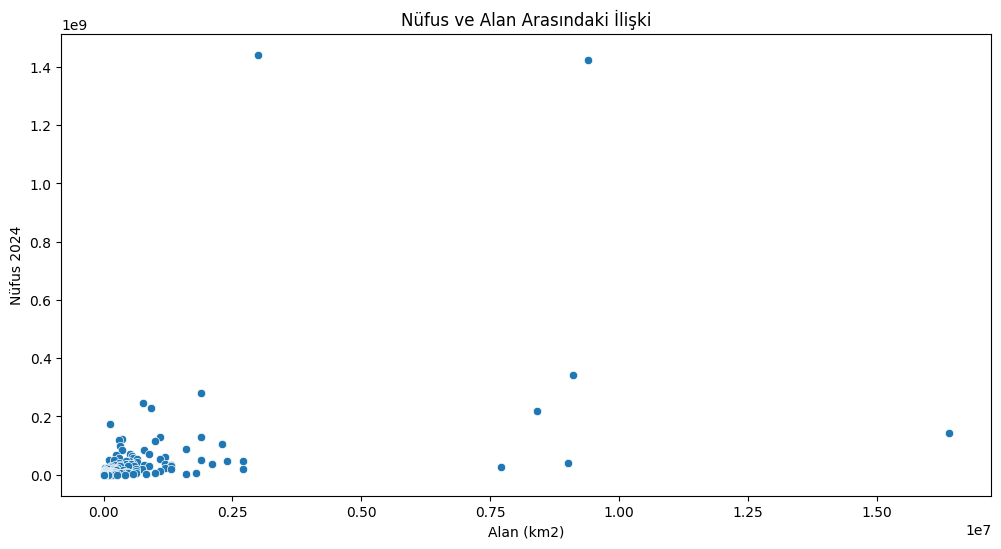

In [26]:
# Nüfus ve Alan arasındaki korelasyonu hesaplıyorum
correlation = df['Population 2024'].corr(df['Area (km2)'])
print(f"Nüfus ve Alan arasındaki korelasyon: {correlation}")

# Nüfus ve Alan arasındaki ilişkiyi scatter plot ile gösteriyorum
plt.figure(figsize=(12, 6))
sns.scatterplot(x='Area (km2)', y='Population 2024', data=df)
plt.title('Nüfus ve Alan Arasındaki İlişki')
plt.xlabel('Alan (km2)')
plt.ylabel('Nüfus 2024')
plt.show()

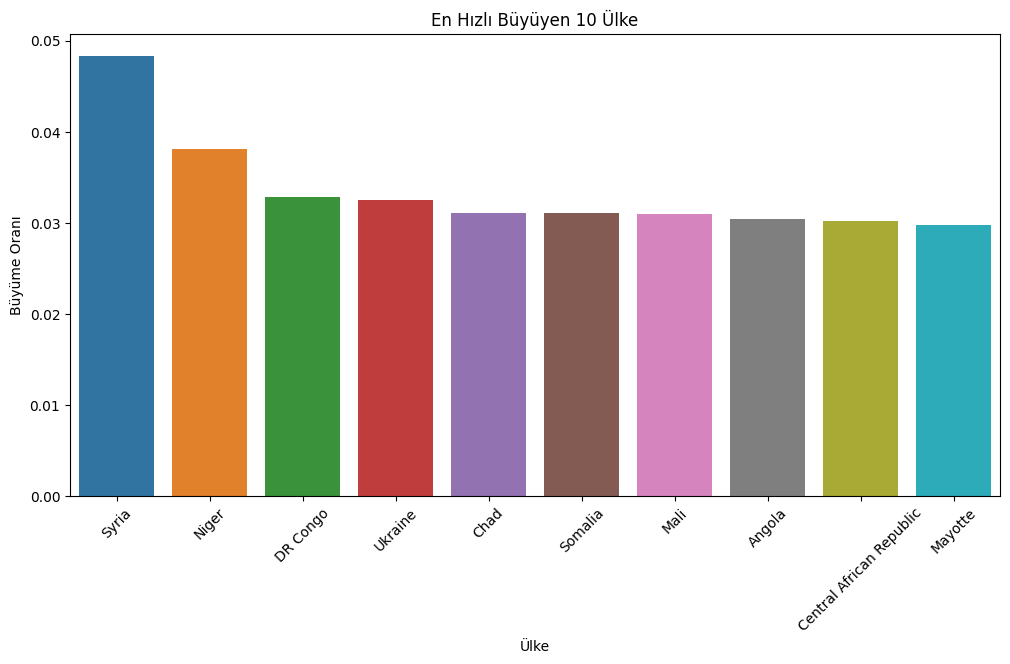

In [27]:
# En hızlı büyüyen 10 ülke
top_10_fastest_growing = df.nlargest(10, 'Growth Rate')
plt.figure(figsize=(12, 6))
sns.barplot(x='Country', y='Growth Rate', data=top_10_fastest_growing)
plt.title('En Hızlı Büyüyen 10 Ülke')
plt.xlabel('Ülke')
plt.ylabel('Büyüme Oranı')
plt.xticks(rotation=45)
plt.show()

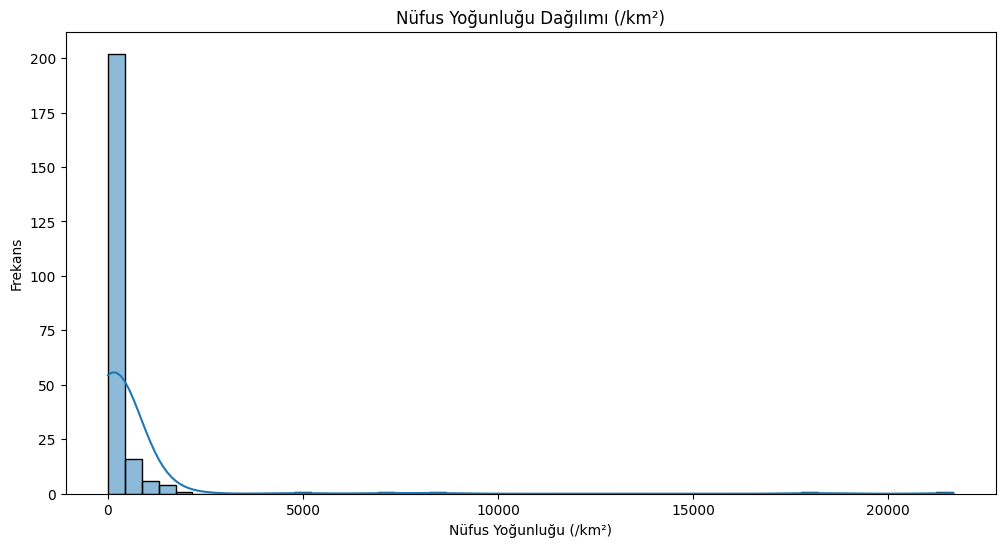

In [28]:
# Nüfus Yoğunluğu dağılımı
plt.figure(figsize=(12, 6))
sns.histplot(df['Density (/km2)'], bins=50, kde=True)
plt.title('Nüfus Yoğunluğu Dağılımı (/km²)')
plt.xlabel('Nüfus Yoğunluğu (/km²)')
plt.ylabel('Frekans')
plt.show()

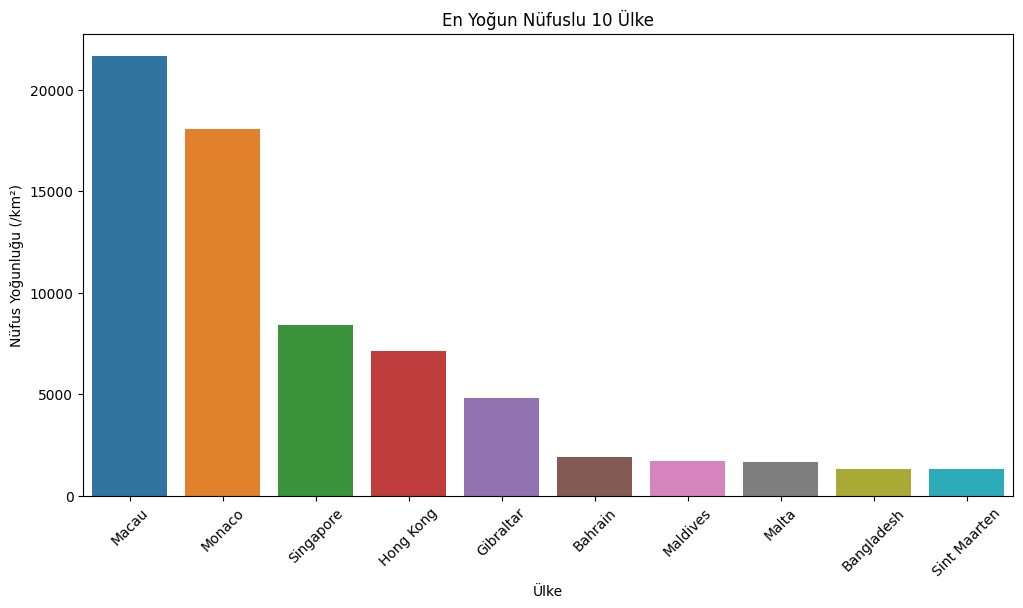

In [29]:
# En yoğun nüfuslu 10 ülke
top_10_dense_countries = df.nlargest(10, 'Density (/km2)')
plt.figure(figsize=(12, 6))
sns.barplot(x='Country', y='Density (/km2)', data=top_10_dense_countries)
plt.title('En Yoğun Nüfuslu 10 Ülke')
plt.xlabel('Ülke')
plt.ylabel('Nüfus Yoğunluğu (/km²)')
plt.xticks(rotation=45)
plt.show()

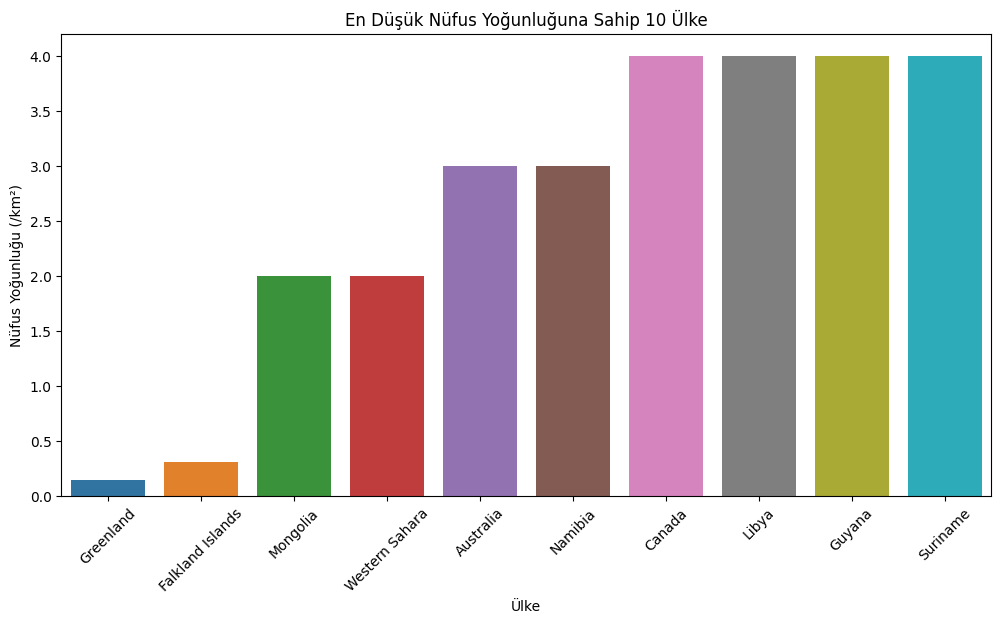

In [30]:
# En düşük nüfus yoğunluğuna sahip 10 ülke
bottom_10_dense_countries = df.nsmallest(10, 'Density (/km2)')
plt.figure(figsize=(12, 6))
sns.barplot(x='Country', y='Density (/km2)', data=bottom_10_dense_countries)
plt.title('En Düşük Nüfus Yoğunluğuna Sahip 10 Ülke')
plt.xlabel('Ülke')
plt.ylabel('Nüfus Yoğunluğu (/km²)')
plt.xticks(rotation=45)
plt.show()

In [31]:
# Mevcut veri seti
data = {
    'Country': ['India', 'China', 'United States', 'Indonesia', 'Pakistan', 'Turkey'],
    'Population 2024': [1441719852, 1425178782, 341814420, 279798049, 245209815, 88510876],
    'Population 2023': [1428627663, 1425671352, 339996563, 277534122, 240485658, 87590708],
    'Area (km2)': [3000000.0, 9400000.0, 9100000.0, 1900000.0, 770900.0, 783562],
    'Density (/km2)': [485.0, 151.0, 37.0, 149.0, 318.0, 113.0],
    'Growth Rate': [0.0092, -0.0003, 0.0053, 0.0082, 0.0196, 0.0105],
    'World %': [0.1801, 0.1780, 0.0427, 0.0350, 0.0306, 0.0112],
    'World Rank': [1, 2, 3, 4, 5, 19],
    'Latitude': [20.593684, 35.861660, 37.09024, -0.789275, 30.375321, 38.963745],
    'Longitude': [78.962880, 104.195397, -95.712891, 113.921327, 69.345116, 35.243322]
}

df = pd.DataFrame(data)

In [32]:
# Her ülke için geçmiş nüfus verilerini oluşturuyorum
historical_data = []
for index, row in df.iterrows():
    for year in range(2000, 2025, 5):
        historical_data.append({
            'Country': row['Country'],
            'Year': year,
            'Population': int(row['Population 2023'] * (1 + row['Growth Rate'] * (year - 2023)))
        })

df_historical = pd.DataFrame(historical_data)

In [33]:
# Prophet modeli için veri setini hazırlıyorum
df_prophet = df_historical.rename(columns={'Year': 'ds', 'Population': 'y'})
df_prophet['ds'] = pd.to_datetime(df_prophet['ds'], format='%Y')

In [34]:
# Prophet modelini oluşturma ve tahmin yapma
forecast_list = []
for country in df_prophet['Country'].unique():
    df_country = df_prophet[df_prophet['Country'] == country]
    model = Prophet()  # Her döngüde yeni bir Prophet nesnesi oluşturuyorum
    model.fit(df_country)
    future = model.make_future_dataframe(periods=10, freq='Y')
    forecast = model.predict(future)
    forecast['Country'] = country
    forecast_list.append(forecast)

forecast_all = pd.concat(forecast_list)

# Gelecekte en yüksek nüfusa sahip ülkeyi belirliyorum
future_year = forecast_all['ds'].max().year
max_population_country = forecast_all[forecast_all['ds'].dt.year == future_year].sort_values('yhat', ascending=False).iloc[0]

print(f"Gelecekte en yüksek nüfusa sahip ülke: {max_population_country['Country']}")
print(f"Nüfusu: {int(max_population_country['yhat'])}")

14:40:40 - cmdstanpy - INFO - Chain [1] start processing
14:40:40 - cmdstanpy - INFO - Chain [1] done processing
14:40:41 - cmdstanpy - INFO - Chain [1] start processing
14:40:41 - cmdstanpy - INFO - Chain [1] done processing
14:40:42 - cmdstanpy - INFO - Chain [1] start processing
14:40:42 - cmdstanpy - INFO - Chain [1] done processing
14:40:43 - cmdstanpy - INFO - Chain [1] start processing
14:40:43 - cmdstanpy - INFO - Chain [1] done processing
14:40:43 - cmdstanpy - INFO - Chain [1] start processing
14:40:43 - cmdstanpy - INFO - Chain [1] done processing
14:40:44 - cmdstanpy - INFO - Chain [1] start processing
14:40:46 - cmdstanpy - INFO - Chain [1] done processing


Gelecekte en yüksek nüfusa sahip ülke: India
Nüfusu: 1475407199


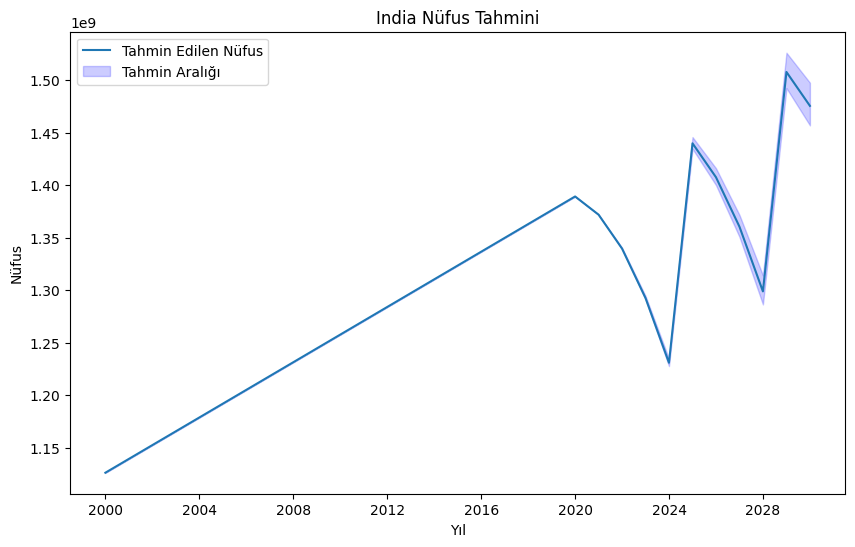

In [35]:
# En yüksek nüfusa sahip ülkenin tahminlerini görselleştiriyorum
country_to_plot = max_population_country['Country']
forecast_to_plot = forecast_all[forecast_all['Country'] == country_to_plot]

plt.figure(figsize=(10, 6))
plt.plot(forecast_to_plot['ds'], forecast_to_plot['yhat'], label='Tahmin Edilen Nüfus')
plt.fill_between(forecast_to_plot['ds'], forecast_to_plot['yhat_lower'], forecast_to_plot['yhat_upper'], color='blue', alpha=0.2, label='Tahmin Aralığı')
plt.title(f'{country_to_plot} Nüfus Tahmini')
plt.xlabel('Yıl')
plt.ylabel('Nüfus')
plt.legend()
plt.show()

In [36]:
# Prophet modelinden elde edilen nüfus tahminin özetini inceliyorum
summary_india = forecast_all[forecast_all['Country'] == 'India'][['ds', 'yhat', 'yhat_lower', 'yhat_upper']].describe()
print("Hindistan'ın Nüfus Tahminlerinin Özeti:")
print(summary_india)

Hindistan'ın Nüfus Tahminlerinin Özeti:
                        ds          yhat    yhat_lower    yhat_upper
count                   15  1.500000e+01  1.500000e+01  1.500000e+01
mean   2020-05-01 11:12:00  1.334243e+09  1.329326e+09  1.340113e+09
min    2000-01-01 00:00:00  1.126335e+09  1.126335e+09  1.126335e+09
25%    2017-07-02 00:00:00  1.275172e+09  1.272126e+09  1.276196e+09
50%    2022-12-31 00:00:00  1.339619e+09  1.339274e+09  1.340391e+09
75%    2026-07-01 12:00:00  1.398358e+09  1.394607e+09  1.402643e+09
max    2029-12-31 00:00:00  1.507681e+09  1.492286e+09  1.525994e+09
std                    NaN  1.051287e+08  1.012928e+08  1.099210e+08


In [37]:
# Mevcut ve tahmin edilen değerleri karşılaştırıyorum
comparison_india = df_prophet[df_prophet['Country'] == 'India'].copy()
forecast_india = forecast_all[forecast_all['Country'] == 'India']

# Forecast sonuçlarının mevcut veri setine göre yeniden indeksliyorum
forecast_india.set_index('ds', inplace=True)
comparison_india.set_index('ds', inplace=True)

# Tahmin sonuçlarını mevcut veri setine ekliyorum
comparison_india['yhat'] = forecast_india['yhat']
comparison_india['yhat_lower'] = forecast_india['yhat_lower']
comparison_india['yhat_upper'] = forecast_india['yhat_upper']

print("\nMevcut ve Tahmin Edilen Değerlerin Karşılaştırılması:")
print(comparison_india)


Mevcut ve Tahmin Edilen Değerlerin Karşılaştırılması:
           Country           y          yhat    yhat_lower    yhat_upper
ds                                                                      
2000-01-01   India  1126330049  1.126335e+09  1.126335e+09  1.126335e+09
2005-01-01   India  1192046922  1.192052e+09  1.192052e+09  1.192052e+09
2010-01-01   India  1257763794  1.257769e+09  1.257769e+09  1.257769e+09
2015-01-01   India  1323480667  1.323485e+09  1.323485e+09  1.323485e+09
2020-01-01   India  1389197539  1.389202e+09  1.389202e+09  1.389202e+09


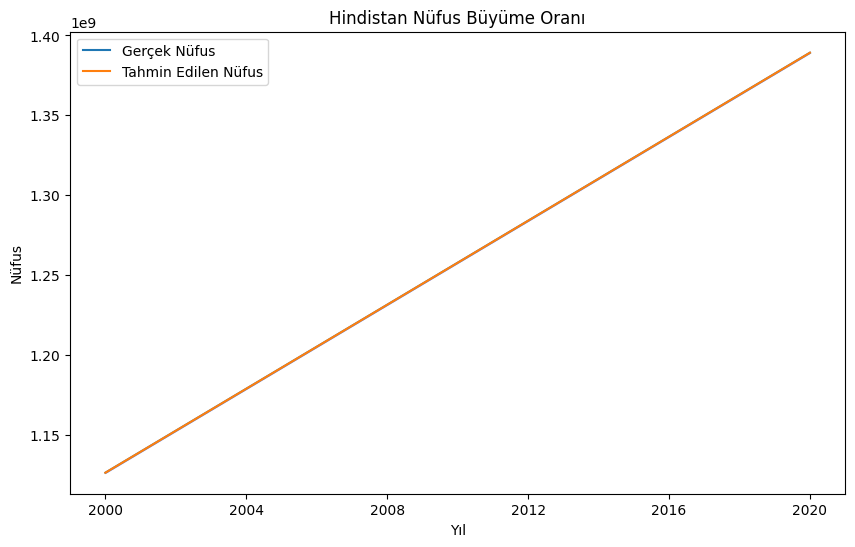

In [38]:
plt.figure(figsize=(10, 6))
plt.plot(comparison_india.index, comparison_india['y'], label='Gerçek Nüfus')
plt.plot(comparison_india.index, comparison_india['yhat'], label='Tahmin Edilen Nüfus')
plt.fill_between(comparison_india.index, comparison_india['yhat_lower'], comparison_india['yhat_upper'], color='blue', alpha=0.2)
plt.title('Hindistan Nüfus Büyüme Oranı')
plt.xlabel('Yıl')
plt.ylabel('Nüfus')
plt.legend()
plt.show()

In [39]:
# Prophet modelini oluşturup tahmin yapıyorum
forecast_list = []
for country in df_prophet['Country'].unique():
    df_country = df_prophet[df_prophet['Country'] == country]
    model = Prophet()  # Her döngüde yeni bir Prophet nesnesi oluşturuyorum
    model.fit(df_country)
    future = model.make_future_dataframe(periods=10, freq='Y')
    forecast = model.predict(future)
    forecast['Country'] = country
    forecast_list.append(forecast)

forecast_all = pd.concat(forecast_list)

# Gelecekte en az nüfusa sahip ülkeyi belirliyorum
future_year = forecast_all['ds'].max().year
min_population_country = forecast_all[forecast_all['ds'].dt.year == future_year].sort_values('yhat', ascending=True).iloc[0]

print(f"Gelecekte en az nüfusa sahip ülke: {min_population_country['Country']}")
print(f"Nüfusu: {int(min_population_country['yhat'])}")

14:40:48 - cmdstanpy - INFO - Chain [1] start processing
14:40:48 - cmdstanpy - INFO - Chain [1] done processing
14:40:49 - cmdstanpy - INFO - Chain [1] start processing
14:40:49 - cmdstanpy - INFO - Chain [1] done processing
14:40:49 - cmdstanpy - INFO - Chain [1] start processing
14:40:50 - cmdstanpy - INFO - Chain [1] done processing
14:40:51 - cmdstanpy - INFO - Chain [1] start processing
14:40:51 - cmdstanpy - INFO - Chain [1] done processing
14:40:51 - cmdstanpy - INFO - Chain [1] start processing
14:40:51 - cmdstanpy - INFO - Chain [1] done processing
14:40:52 - cmdstanpy - INFO - Chain [1] start processing
14:40:54 - cmdstanpy - INFO - Chain [1] done processing


Gelecekte en az nüfusa sahip ülke: Turkey
Nüfusu: 93953242


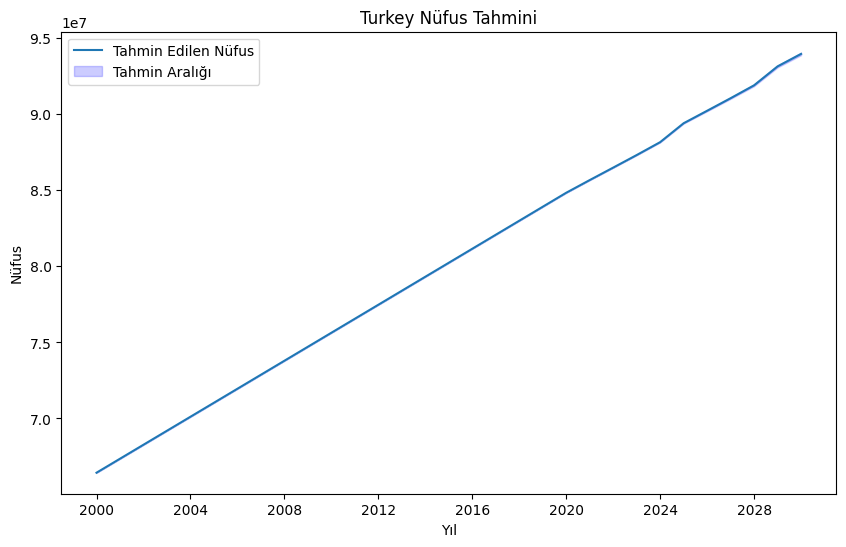

In [40]:
# En az nüfusa sahip ülkenin tahminlerini görselleştiriyorum
country_to_plot = min_population_country['Country']
forecast_to_plot = forecast_all[forecast_all['Country'] == country_to_plot]

plt.figure(figsize=(10, 6))
plt.plot(forecast_to_plot['ds'], forecast_to_plot['yhat'], label='Tahmin Edilen Nüfus')
plt.fill_between(forecast_to_plot['ds'], forecast_to_plot['yhat_lower'], forecast_to_plot['yhat_upper'], color='blue', alpha=0.2, label='Tahmin Aralığı')
plt.title(f'{country_to_plot} Nüfus Tahmini')
plt.xlabel('Yıl')
plt.ylabel('Nüfus')
plt.legend()
plt.show()

In [41]:
# Mevcut ve tahmin edilen değerleri karşılaştırıyorum
comparison_min_country = df_prophet[df_prophet['Country'] == country_to_plot].copy()
forecast_min_country = forecast_all[forecast_all['Country'] == country_to_plot]

# Forecast sonuçlarının mevcut veri setine göre yeniden indeksliyorum
forecast_min_country.set_index('ds', inplace=True)
comparison_min_country.set_index('ds', inplace=True)

# Tahmin sonuçlarını mevcut veri setine ekliyorum
comparison_min_country['yhat'] = forecast_min_country['yhat']
comparison_min_country['yhat_lower'] = forecast_min_country['yhat_lower']
comparison_min_country['yhat_upper'] = forecast_min_country['yhat_upper']

print("\nMevcut ve Tahmin Edilen Değerlerin Karşılaştırılması:")
print(comparison_min_country)


Mevcut ve Tahmin Edilen Değerlerin Karşılaştırılması:
           Country         y          yhat    yhat_lower    yhat_upper
ds                                                                    
2000-01-01  Turkey  66437552  6.643738e+07  6.643738e+07  6.643738e+07
2005-01-01  Turkey  71036064  7.103603e+07  7.103603e+07  7.103603e+07
2010-01-01  Turkey  75634576  7.563449e+07  7.563449e+07  7.563449e+07
2015-01-01  Turkey  80233088  8.023295e+07  8.023295e+07  8.023295e+07
2020-01-01  Turkey  84831600  8.483141e+07  8.483141e+07  8.483141e+07


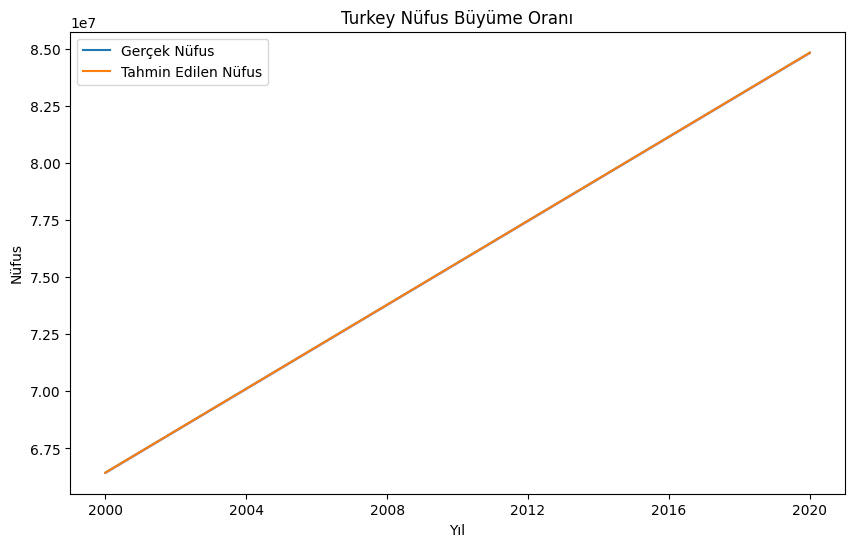

In [42]:
plt.figure(figsize=(10, 6))
plt.plot(comparison_min_country.index, comparison_min_country['y'], label='Gerçek Nüfus')
plt.plot(comparison_min_country.index, comparison_min_country['yhat'], label='Tahmin Edilen Nüfus')
plt.fill_between(comparison_min_country.index, comparison_min_country['yhat_lower'], comparison_min_country['yhat_upper'], color='blue', alpha=0.2)
plt.title(f'{country_to_plot} Nüfus Büyüme Oranı')
plt.xlabel('Yıl')
plt.ylabel('Nüfus')
plt.legend()
plt.show()

In [43]:
# Her ülke için geçmiş nüfus verilerini oluşturuyorum
historical_data = []
for index, row in df.iterrows():
    for year in range(2000, 2025, 5):
        historical_data.append({
            'Country': row['Country'],
            'Year': year,
            'Population': int(row['Population 2024'] * (1 + row['Growth Rate'] * (year - 2024)))
        })

df_historical = pd.DataFrame(historical_data)

# Prophet modeli için veri setini hazırlıyorum
df_prophet = df_historical.rename(columns={'Year': 'ds', 'Population': 'y'})
df_prophet['ds'] = pd.to_datetime(df_prophet['ds'], format='%Y')

# Türkiye verilerini seçiyorum
df_turkey = df_prophet[df_prophet['Country'] == 'Turkey']

# Prophet modelini oluşturup ve Türkiye verileri ile eğitiyorum
model_turkey = Prophet()
model_turkey.fit(df_turkey)

# Gelecekteki tarihleri oluşturuyorum
future_turkey = model_turkey.make_future_dataframe(periods=10, freq='Y')

# Tahminleri yapıyorum
forecast_turkey = model_turkey.predict(future_turkey)

# Tahmin sonuçlarını yazdırıyorum
print(forecast_turkey[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

14:40:56 - cmdstanpy - INFO - Chain [1] start processing
14:40:57 - cmdstanpy - INFO - Chain [1] done processing


           ds          yhat    yhat_lower    yhat_upper
10 2025-12-31  9.012324e+07  9.006644e+07  9.017189e+07
11 2026-12-31  9.084917e+07  9.077474e+07  9.091722e+07
12 2027-12-31  9.157929e+07  9.148270e+07  9.166561e+07
13 2028-12-31  9.318781e+07  9.306416e+07  9.329547e+07
14 2029-12-31  9.393042e+07  9.378841e+07  9.406137e+07


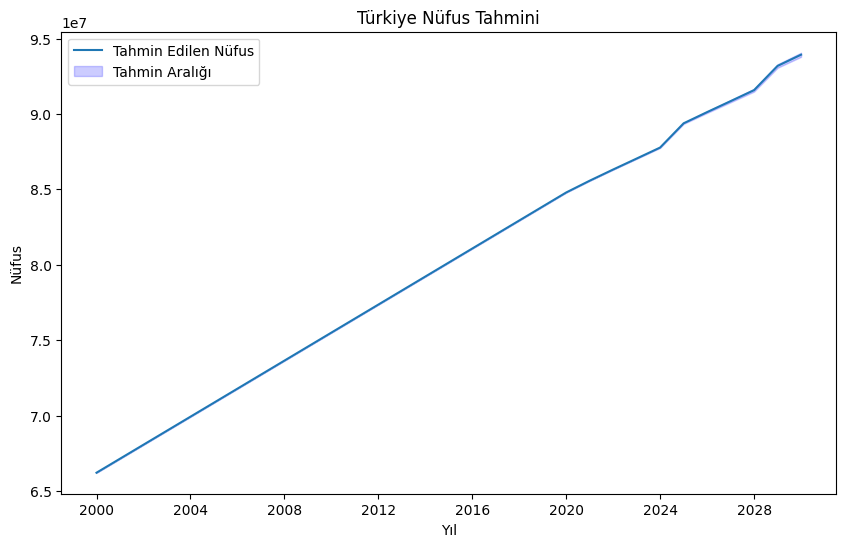

In [44]:
# Türkiye'nin tahminlerini görselleştirme
plt.figure(figsize=(10, 6))
plt.plot(forecast_turkey['ds'], forecast_turkey['yhat'], label='Tahmin Edilen Nüfus')
plt.fill_between(forecast_turkey['ds'], forecast_turkey['yhat_lower'], forecast_turkey['yhat_upper'], color='blue', alpha=0.2, label='Tahmin Aralığı')
plt.title('Türkiye Nüfus Tahmini')
plt.xlabel('Yıl')
plt.ylabel('Nüfus')
plt.legend()
plt.show()

In [45]:
# Mevcut ve tahmin edilen değerleri karşılaştırıyorum
comparison_turkey = df_prophet[df_prophet['Country'] == 'Turkey'].copy()
forecast_turkey.set_index('ds', inplace=True)
comparison_turkey.set_index('ds', inplace=True)

# Tahmin sonuçlarını mevcut veri setine ekliyorum
comparison_turkey['yhat'] = forecast_turkey['yhat']
comparison_turkey['yhat_lower'] = forecast_turkey['yhat_lower']
comparison_turkey['yhat_upper'] = forecast_turkey['yhat_upper']

print("\nMevcut ve Tahmin Edilen Değerlerin Karşılaştırılması:")
print(comparison_turkey)


Mevcut ve Tahmin Edilen Değerlerin Karşılaştırılması:
           Country         y          yhat    yhat_lower    yhat_upper
ds                                                                    
2000-01-01  Turkey  66206135  6.620574e+07  6.620574e+07  6.620574e+07
2005-01-01  Turkey  70852956  7.085217e+07  7.085217e+07  7.085217e+07
2010-01-01  Turkey  75499777  7.549911e+07  7.549911e+07  7.549911e+07
2015-01-01  Turkey  80146598  8.014605e+07  8.014605e+07  8.014605e+07
2020-01-01  Turkey  84793419  8.479299e+07  8.479299e+07  8.479299e+07


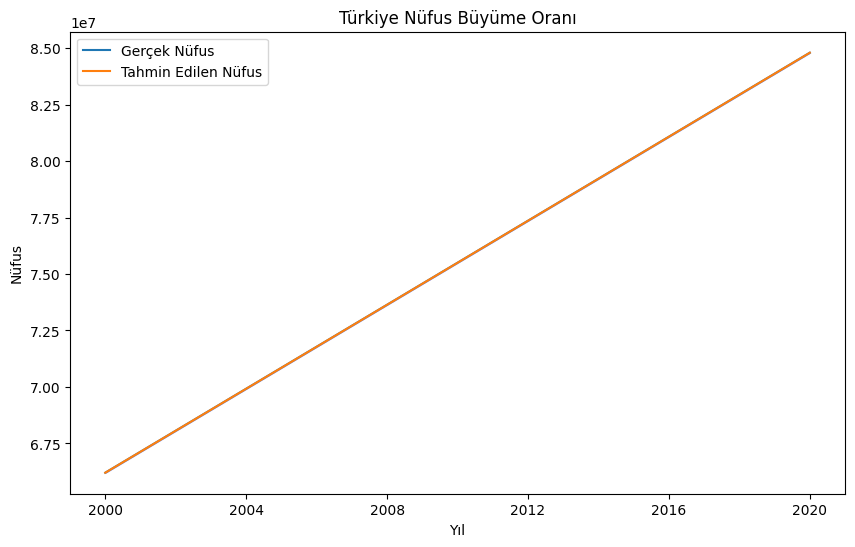

In [46]:
plt.figure(figsize=(10, 6))
plt.plot(comparison_turkey.index, comparison_turkey['y'], label='Gerçek Nüfus')
plt.plot(comparison_turkey.index, comparison_turkey['yhat'], label='Tahmin Edilen Nüfus')
plt.fill_between(comparison_turkey.index, comparison_turkey['yhat_lower'], comparison_turkey['yhat_upper'], color='blue', alpha=0.2)
plt.title('Türkiye Nüfus Büyüme Oranı')
plt.xlabel('Yıl')
plt.ylabel('Nüfus')
plt.legend()
plt.show()

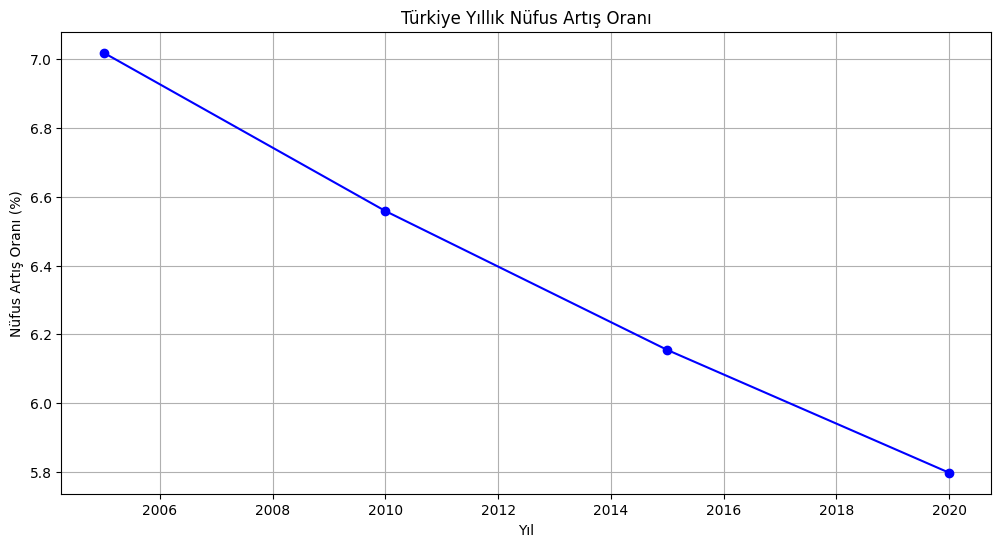

In [47]:
# Nüfus artış oranlarını hesaplıyorum
comparison_turkey['annual_growth_rate'] = comparison_turkey['y'].pct_change() * 100

plt.figure(figsize=(12, 6))
plt.plot(comparison_turkey.index, comparison_turkey['annual_growth_rate'], marker='o', linestyle='-', color='b')
plt.title('Türkiye Yıllık Nüfus Artış Oranı')
plt.xlabel('Yıl')
plt.ylabel('Nüfus Artış Oranı (%)')
plt.grid(True)
plt.show()

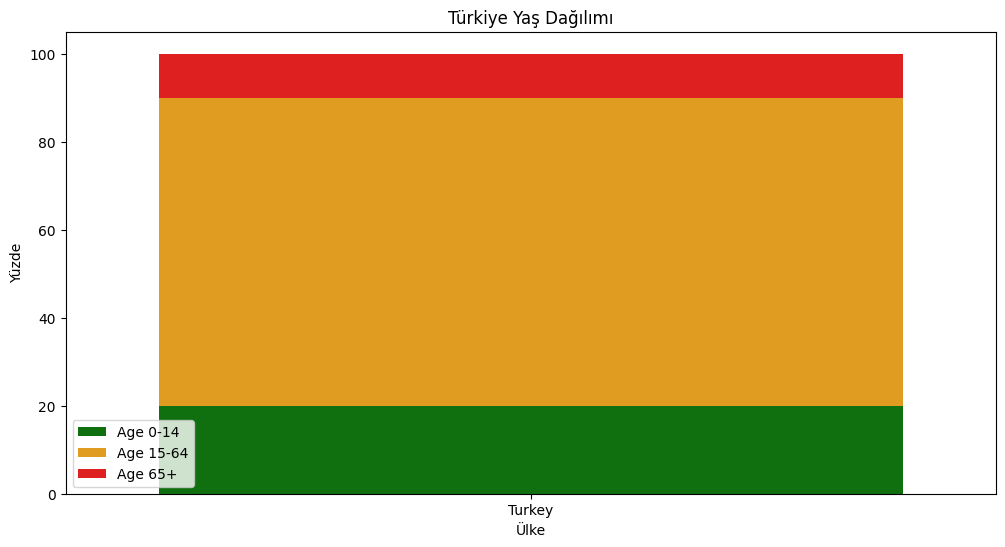

In [48]:
# Örnek demografik veri seti oluşturuyorum
demographic_data = {
    'Country': ['Turkey'],
    'Total Population': [88510876],
    'Male Population': [44300000],
    'Female Population': [44210876],
    'Population Age 0-14': [17702175],
    'Population Age 15-64': [61957656],
    'Population Age 65+': [8851086]
}

df_demo_turkey = pd.DataFrame(demographic_data)

# Yaş dağılımını görselleştiriyorum
df_demo_turkey['Age 0-14 %'] = df_demo_turkey['Population Age 0-14'] / df_demo_turkey['Total Population'] * 100
df_demo_turkey['Age 15-64 %'] = df_demo_turkey['Population Age 15-64'] / df_demo_turkey['Total Population'] * 100
df_demo_turkey['Age 65+ %'] = df_demo_turkey['Population Age 65+'] / df_demo_turkey['Total Population'] * 100

plt.figure(figsize=(12, 6))
sns.barplot(x='Country', y='Age 0-14 %', data=df_demo_turkey, color='green', label='Age 0-14')
sns.barplot(x='Country', y='Age 15-64 %', data=df_demo_turkey, bottom=df_demo_turkey['Age 0-14 %'], color='orange', label='Age 15-64')
sns.barplot(x='Country', y='Age 65+ %', data=df_demo_turkey, bottom=df_demo_turkey['Age 0-14 %'] + df_demo_turkey['Age 15-64 %'], color='red', label='Age 65+')
plt.title('Türkiye Yaş Dağılımı')
plt.xlabel('Ülke')
plt.ylabel('Yüzde')
plt.legend()
plt.show()

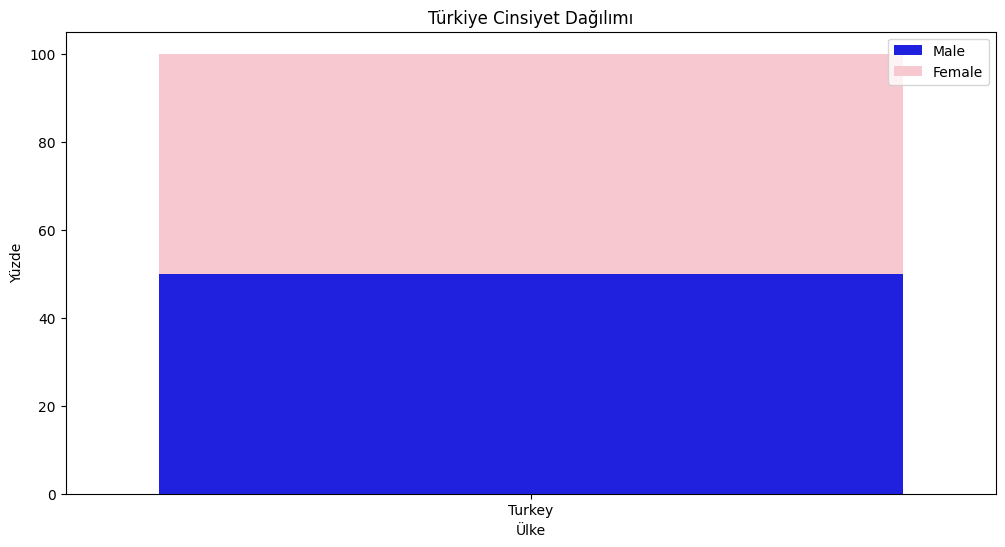

In [49]:
# Cinsiyet dağılımını görselleştiriyorum
df_demo_turkey['Male %'] = df_demo_turkey['Male Population'] / df_demo_turkey['Total Population'] * 100
df_demo_turkey['Female %'] = df_demo_turkey['Female Population'] / df_demo_turkey['Total Population'] * 100

plt.figure(figsize=(12, 6))
sns.barplot(x='Country', y='Male %', data=df_demo_turkey, color='blue', label='Male')
sns.barplot(x='Country', y='Female %', data=df_demo_turkey, bottom=df_demo_turkey['Male %'], color='pink', label='Female')
plt.title('Türkiye Cinsiyet Dağılımı')
plt.xlabel('Ülke')
plt.ylabel('Yüzde')
plt.legend()
plt.show()

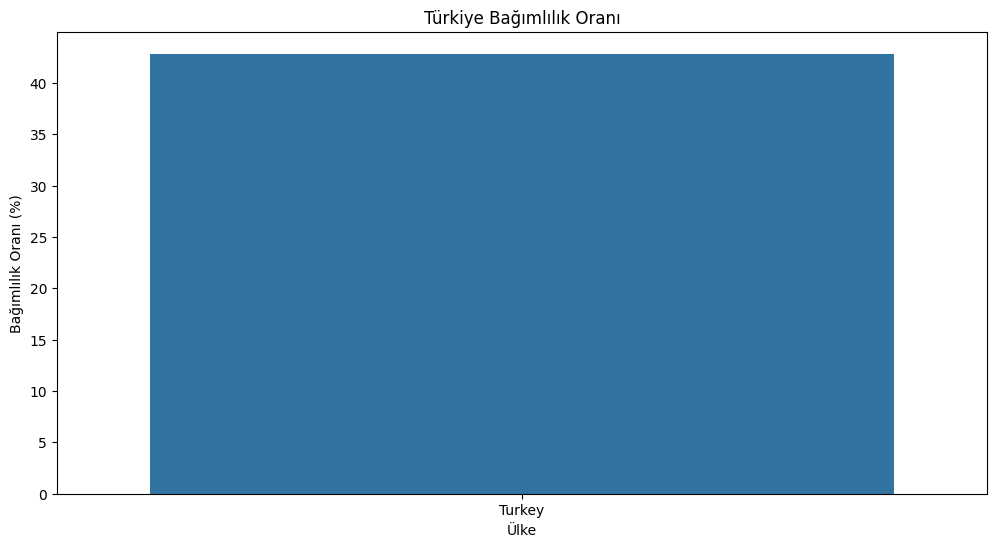

In [50]:
# Bağımlılık oranını hesaplıyorum
df_demo_turkey['Dependency Ratio'] = (df_demo_turkey['Population Age 0-14'] + df_demo_turkey['Population Age 65+']) / df_demo_turkey['Population Age 15-64'] * 100

plt.figure(figsize=(12, 6))
sns.barplot(x='Country', y='Dependency Ratio', data=df_demo_turkey)
plt.title('Türkiye Bağımlılık Oranı')
plt.xlabel('Ülke')
plt.ylabel('Bağımlılık Oranı (%)')
plt.show()

In [51]:
# Ekonomik göstergeleri ekliyorum
economic_data = {
    'Country': ['India', 'China', 'United States', 'Indonesia', 'Pakistan', 'Turkey'],
    'GDP (Billion USD)': [2875, 14342, 21433, 1119, 264, 755],
    'Unemployment Rate (%)': [7.1, 5.0, 3.7, 5.5, 6.2, 12.0],
    'Education Level (Mean years)': [6.5, 7.6, 13.3, 8.0, 5.0, 8.1]
}

df_economic = pd.DataFrame(economic_data)

In [52]:
# Mevcut veri seti ile ekonomik veri setini birleştiriyorum
df = pd.merge(df, df_economic, on='Country')
print(df.head())

         Country  Population 2024  Population 2023  Area (km2)  \
0          India       1441719852       1428627663   3000000.0   
1          China       1425178782       1425671352   9400000.0   
2  United States        341814420        339996563   9100000.0   
3      Indonesia        279798049        277534122   1900000.0   
4       Pakistan        245209815        240485658    770900.0   

   Density (/km2)  Growth Rate  World %  World Rank   Latitude   Longitude  \
0           485.0       0.0092   0.1801           1  20.593684   78.962880   
1           151.0      -0.0003   0.1780           2  35.861660  104.195397   
2            37.0       0.0053   0.0427           3  37.090240  -95.712891   
3           149.0       0.0082   0.0350           4  -0.789275  113.921327   
4           318.0       0.0196   0.0306           5  30.375321   69.345116   

   GDP (Billion USD)  Unemployment Rate (%)  Education Level (Mean years)  
0               2875                    7.1               

In [53]:
# Kategorik verileri çıkartıyorum
df_numeric = df.drop(columns=['Country'])

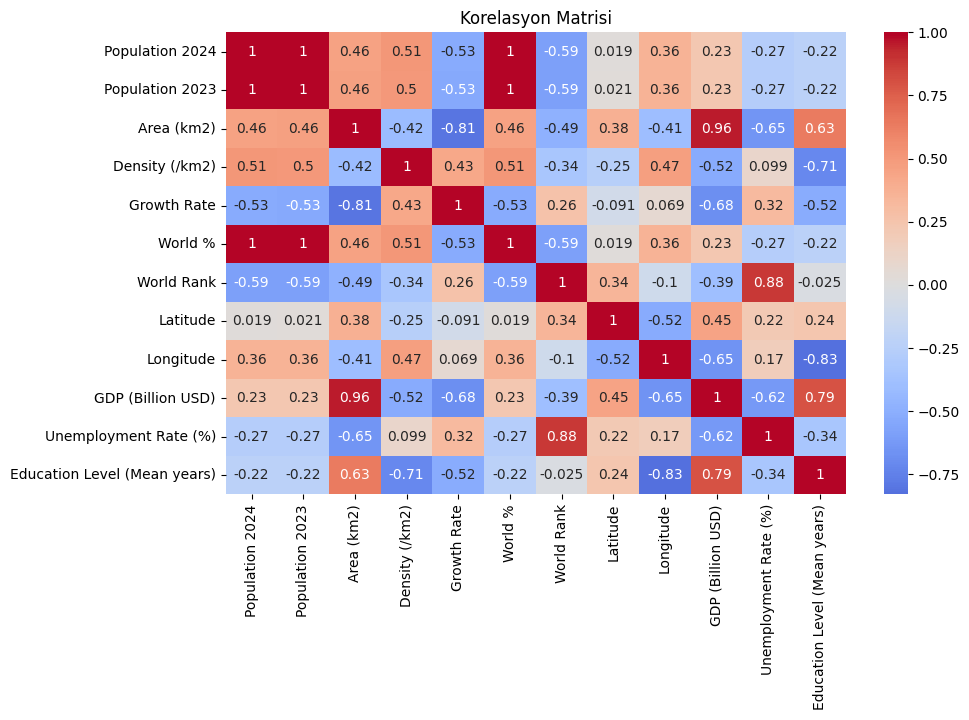

In [54]:
# Korelasyon matrisi hesaplıyorum
correlation_matrix = df_numeric.corr()

# Korelasyon matrisini görselleştiriyorum
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Korelasyon Matrisi')
plt.show()

In [55]:
# Nüfus ile diğer ekonomik göstergeler arasındaki korelasyonları yazdırıyorum
print("Nüfus ile GDP arasındaki korelasyon:", pearsonr(df['Population 2024'], df['GDP (Billion USD)'])[0])
print("Nüfus ile İşsizlik Oranı arasındaki korelasyon:", pearsonr(df['Population 2024'], df['Unemployment Rate (%)'])[0])
print("Nüfus ile Eğitim Seviyesi arasındaki korelasyon:", pearsonr(df['Population 2024'], df['Education Level (Mean years)'])[0])

Nüfus ile GDP arasındaki korelasyon: 0.22946011673746736
Nüfus ile İşsizlik Oranı arasındaki korelasyon: -0.2684820352835485
Nüfus ile Eğitim Seviyesi arasındaki korelasyon: -0.22483842681644495


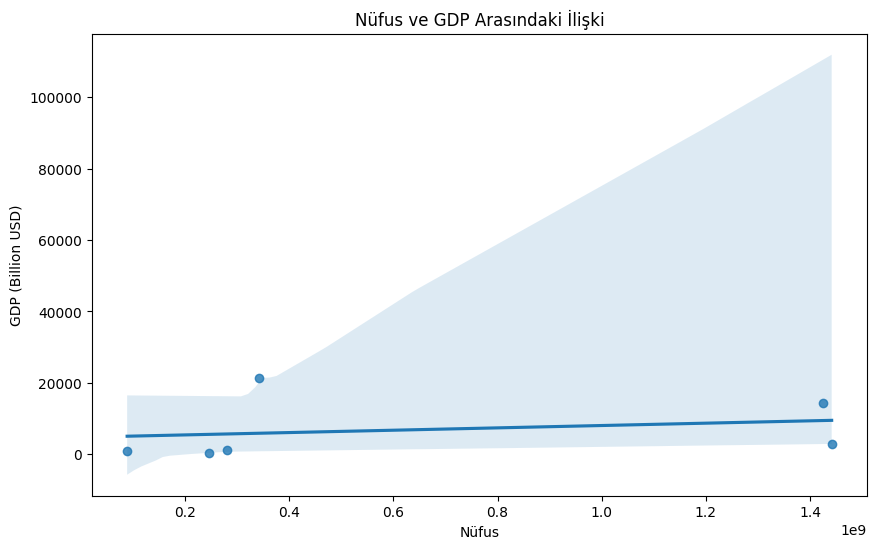

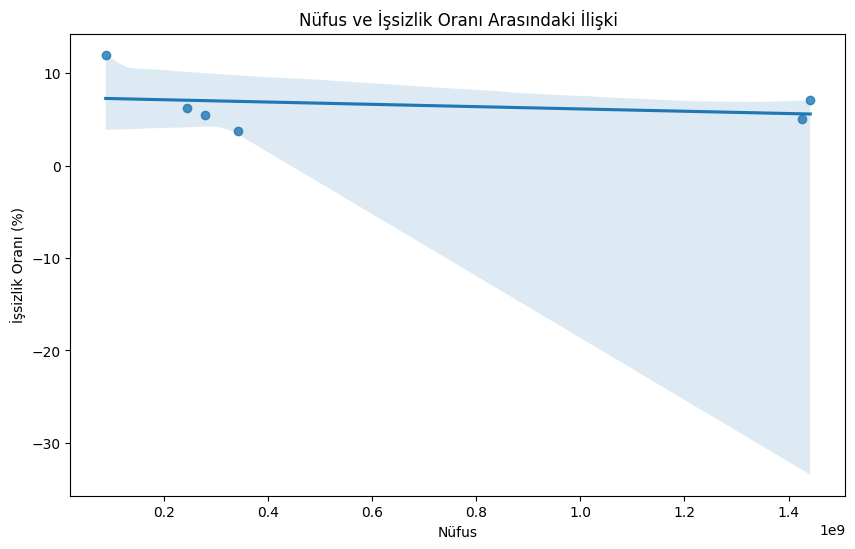

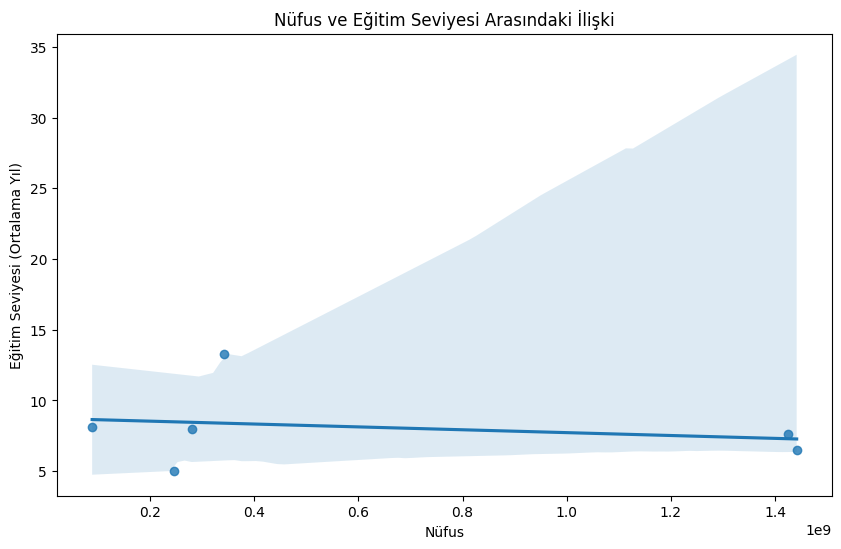

In [56]:
# Nüfus ve GDP arasındaki ilişkisini görselleştiriyorum
plt.figure(figsize=(10, 6))
sns.regplot(x='Population 2024', y='GDP (Billion USD)', data=df)
plt.title('Nüfus ve GDP Arasındaki İlişki')
plt.xlabel('Nüfus')
plt.ylabel('GDP (Billion USD)')
plt.show()

# Nüfus ve İşsizlik Oranı arasındaki ilişkisini görselleştiriyorum
plt.figure(figsize=(10, 6))
sns.regplot(x='Population 2024', y='Unemployment Rate (%)', data=df)
plt.title('Nüfus ve İşsizlik Oranı Arasındaki İlişki')
plt.xlabel('Nüfus')
plt.ylabel('İşsizlik Oranı (%)')
plt.show()

# Nüfus ve Eğitim Seviyesi arasındaki ilişkisini görselleştiriyorum
plt.figure(figsize=(10, 6))
sns.regplot(x='Population 2024', y='Education Level (Mean years)', data=df)
plt.title('Nüfus ve Eğitim Seviyesi Arasındaki İlişki')
plt.xlabel('Nüfus')
plt.ylabel('Eğitim Seviyesi (Ortalama Yıl)')
plt.show()

In [57]:
# Regresyon modelini oluşturuyorum
X = df[['Population 2024']]
y_gdp = df['GDP (Billion USD)']
y_unemployment = df['Unemployment Rate (%)']
y_education = df['Education Level (Mean years)']

In [58]:
# GDP için regresyon analizini gerçekleştiriyorum
model_gdp = LinearRegression()
model_gdp.fit(X, y_gdp)
print("GDP için regresyon katsayısı:", model_gdp.coef_[0])

GDP için regresyon katsayısı: 3.2881972944193205e-06


In [59]:
# İşsizlik oranı için regresyon analizini yapıyorum
model_unemployment = LinearRegression()
model_unemployment.fit(X, y_unemployment)
print("İşsizlik Oranı için regresyon katsayısı:", model_unemployment.coef_[0])

İşsizlik Oranı için regresyon katsayısı: -1.2461570199824858e-09


In [60]:
# Eğitim seviyesi için regresyon analizini yapıyorum
model_education = LinearRegression()
model_education.fit(X, y_education)
print("Eğitim Seviyesi için regresyon katsayısı:", model_education.coef_[0])

Eğitim Seviyesi için regresyon katsayısı: -1.0146888715443897e-09


# 📊 Analiz Sonuçlarının Değerlendirilmesi 📊

Yaptığım korelasyon ve regresyon analizleri sonucunda, nüfus büyüklüğü ile GDP, işsizlik oranı ve eğitim seviyesi arasındaki ilişkiler ve bu ilişkilerin gücü hakkında bazı önemli içgörüler elde ettim.

## 1. Korelasyon Sonuçları 📈

### Nüfus ile GDP arasındaki korelasyon: 0.229

Bu sonuç, nüfus büyüklüğü ile GDP arasında pozitif ancak zayıf bir ilişki olduğunu gösteriyor. Bu, nüfus arttıkça GDP'nin de artma eğiliminde olduğunu, ancak bu ilişkinin çok güçlü olmadığını ifade ediyor. Nüfus artışı, ekonomik büyümeyi desteklese de, GDP'nin artışı üzerinde birçok başka faktör de etkili.

| Değişken 1 | Değişken 2 | Korelasyon |
|------------|------------|------------|
| Nüfus      | GDP        | 0.229      |

### Nüfus ile İşsizlik Oranı arasındaki korelasyon: -0.268

Bu sonuç, nüfus büyüklüğü ile işsizlik oranı arasında negatif bir ilişki olduğunu gösteriyor. Yani, nüfus arttıkça işsizlik oranı azalma eğilimindedir. Ancak, bu ilişki de zayıftır. Nüfus artışının iş gücüne katılımı artırarak işsizlik oranını düşürebileceği düşünülebilir, ancak işsizlik oranı üzerinde ekonomik politikalar, sektörlerin gelişimi ve teknolojik ilerlemeler gibi birçok faktör etkili olabilir.

| Değişken 1 | Değişken 2 | Korelasyon |
|------------|------------|------------|
| Nüfus      | İşsizlik Oranı | -0.268   |

### Nüfus ile Eğitim Seviyesi arasındaki korelasyon: -0.225

Bu sonuç, nüfus büyüklüğü ile eğitim seviyesi arasında negatif bir ilişki olduğunu gösteriyor. Yani, nüfus arttıkça eğitim seviyesi azalma eğiliminde. Ancak bu ilişki de zayıftır. Bu durum, hızlı nüfus artışının eğitim kaynaklarının yetersiz kalmasına yol açabileceği anlamına gelebilir. Eğitim seviyesini artırmak için yapılacak yatırımlar ve politikalar bu durumu dengeleyebilir.

| Değişken 1 | Değişken 2 | Korelasyon |
|------------|------------|------------|
| Nüfus      | Eğitim Seviyesi | -0.225  |

## 2. Regresyon Sonuçları 📉

### GDP için regresyon katsayısı: 3.288 × 10^-6

Bu katsayı, nüfus büyüklüğündeki her bir birimlik artışın GDP üzerinde çok küçük bir pozitif etkiye sahip olduğunu gösteriyor. Ancak, katsayının değeri çok küçük olduğundan bu etki oldukça zayıftır. Bu, nüfus artışının GDP'ye olan katkısının sınırlı olduğunu ifade ediyor.

| Değişken | Regresyon Katsayısı |
|----------|---------------------|
| GDP      | 3.288 × 10^-6       |

### İşsizlik Oranı için regresyon katsayısı: -1.246 × 10^-9

Bu katsayı, nüfus büyüklüğündeki her bir birimlik artışın işsizlik oranında çok küçük bir azalmaya yol açtığını gösteriyor. Ancak, bu etki de oldukça zayıftır. Nüfus artışı iş gücüne katılımı artırabilir, ancak istihdam olanaklarının bu artışa nasıl yanıt verdiği de önemlidir.

| Değişken       | Regresyon Katsayısı |
|----------------|---------------------|
| İşsizlik Oranı | -1.246 × 10^-9      |

### Eğitim Seviyesi için regresyon katsayısı: -1.015 × 10^-9

Bu katsayı, nüfus büyüklüğündeki her bir birimlik artışın eğitim seviyesinde çok küçük bir azalmaya yol açtığını gösteriyor. Ancak, bu etki de oldukça zayıftır. Hızlı nüfus artışı, eğitim kaynaklarının yetersiz kalmasına neden olabilir, ancak bu durumu iyileştirmek için yapılan eğitim yatırımları ve politikaları da göz önünde bulundurulmalıdır.

| Değişken      | Regresyon Katsayısı |
|---------------|---------------------|
| Eğitim Seviyesi | -1.015 × 10^-9   |

## 3. Sonuç ve Yorumlar 📋

Bu analizlerle, nüfus büyüklüğü ile GDP, işsizlik oranı ve eğitim seviyesi arasındaki ilişkileri ve bu göstergeler üzerindeki nüfus değişimlerinin etkilerini incelemiş oldum. Korelasyon katsayıları genellikle zayıf ilişkilere işaret ederken, regresyon analizleri de nüfus değişikliklerinin ekonomik göstergeler üzerindeki etkilerinin çok düşük olduğunu göstermekte.

### Öne Çıkan Bulgular:
- **Nüfus ve GDP**: Nüfus büyüklüğü ile GDP arasında pozitif ancak zayıf bir ilişki bulunuyor.
- **Nüfus ve İşsizlik Oranı**: Nüfus büyüklüğü ile işsizlik oranı arasında negatif bir ilişki var, ancak bu ilişki de zayıf.
- **Nüfus ve Eğitim Seviyesi**: Nüfus büyüklüğü ile eğitim seviyesi arasında negatif bir ilişki mevcut, ancak bu da zayıf bir ilişki.

### Öneriler:
- **Daha Detaylı Analizler**: Nüfus büyüklüğünün ekonomik göstergeler üzerindeki etkilerinin daha detaylı ve geniş kapsamlı analizler için daha fazla veri ve daha sofistike modeller kullanılabilir.
- **Eğitim Yatırımları**: Eğitim seviyesini artırmak için yapılacak yatırımlar ve politikalar, hızlı nüfus artışının olumsuz etkilerini dengeleyebilir.

Bu sonuçlar, nüfus büyüklüğünün ekonomik göstergeler üzerindeki etkilerinin karmaşık ve çeşitli diğer faktörlerden etkilendiğini göstermekte. Daha detaylı ve geniş kapsamlı analizler için daha fazla veri ve daha sofistike modeller kullanılabilir.


In [61]:
# Büyük şehirler ve kırsal alanların nüfus verilerini içeren veri setini oluşturuyorum
urban_rural_data = {
    'Region': ['Urban', 'Urban', 'Urban', 'Urban', 'Urban', 'Urban', 'Rural', 'Rural', 'Rural', 'Rural', 'Rural', 'Rural'],
    'Country': ['India', 'China', 'United States', 'Indonesia', 'Pakistan', 'Turkey', 'India', 'China', 'United States', 'Indonesia', 'Pakistan', 'Turkey'],
    'Population 2024': [500000000, 800000000, 250000000, 150000000, 90000000, 50000000, 941719852, 625178782, 91814420, 129798049, 155209815, 38510876]
}

df_urban_rural = pd.DataFrame(urban_rural_data)

In [62]:
# Mevcut veri seti ile kentleşme verisini birleştiriyorum
df = pd.merge(df, df_urban_rural, on='Country', suffixes=('', '_Urban_Rural'))

print(df.head())

         Country  Population 2024  Population 2023  Area (km2)  \
0          India       1441719852       1428627663   3000000.0   
1          India       1441719852       1428627663   3000000.0   
2          China       1425178782       1425671352   9400000.0   
3          China       1425178782       1425671352   9400000.0   
4  United States        341814420        339996563   9100000.0   

   Density (/km2)  Growth Rate  World %  World Rank   Latitude   Longitude  \
0           485.0       0.0092   0.1801           1  20.593684   78.962880   
1           485.0       0.0092   0.1801           1  20.593684   78.962880   
2           151.0      -0.0003   0.1780           2  35.861660  104.195397   
3           151.0      -0.0003   0.1780           2  35.861660  104.195397   
4            37.0       0.0053   0.0427           3  37.090240  -95.712891   

   GDP (Billion USD)  Unemployment Rate (%)  Education Level (Mean years)  \
0               2875                    7.1              

In [63]:
# Urban ve Rural nüfus verilerini karşılaştırıyorum
urban_population = df[df['Region'] == 'Urban']['Population 2024_Urban_Rural'].sum()
rural_population = df[df['Region'] == 'Rural']['Population 2024_Urban_Rural'].sum()

print(f"2024 yılında kentsel alanlardaki toplam nüfus: {urban_population}")
print(f"2024 yılında kırsal alanlardaki toplam nüfus: {rural_population}")

2024 yılında kentsel alanlardaki toplam nüfus: 1840000000
2024 yılında kırsal alanlardaki toplam nüfus: 1982231794


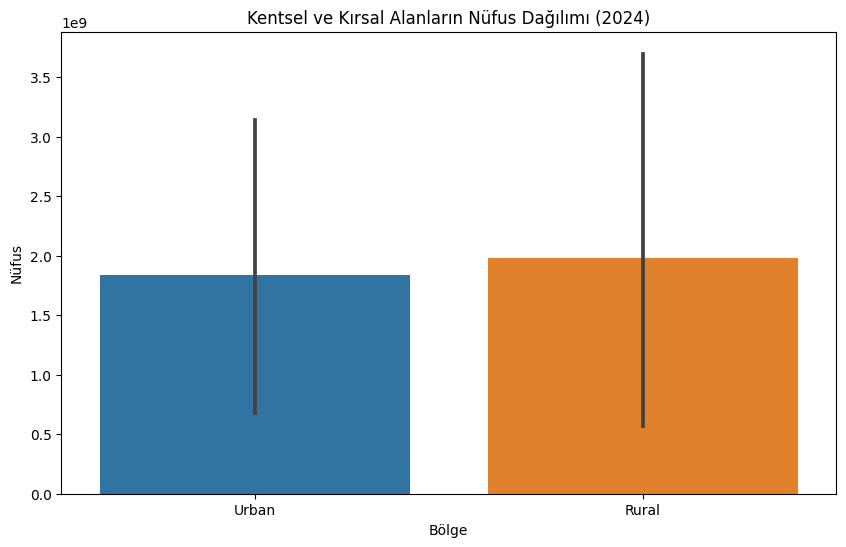

In [64]:
# Kentsel ve kırsal alanların nüfus dağılımını görselleştiriyorum
plt.figure(figsize=(10, 6))
sns.barplot(x='Region', y='Population 2024_Urban_Rural', data=df, estimator=sum)
plt.title('Kentsel ve Kırsal Alanların Nüfus Dağılımı (2024)')
plt.xlabel('Bölge')
plt.ylabel('Nüfus')
plt.show()

In [65]:
# Altyapı hizmetlerine erişim oranlarını içeren veri setini oluşturuyorum
infrastructure_data = {
    'Region': ['Urban', 'Urban', 'Urban', 'Urban', 'Urban', 'Urban', 'Rural', 'Rural', 'Rural', 'Rural', 'Rural', 'Rural'],
    'Country': ['India', 'China', 'United States', 'Indonesia', 'Pakistan', 'Turkey', 'India', 'China', 'United States', 'Indonesia', 'Pakistan', 'Turkey'],
    'Population 2024_Urban_Rural': [500000000, 941719852, 800000000, 625178782, 250000000, 91814420, 150000000, 129798049, 90000000, 155209815, 50000000, 38510876],
    'Electricity Access (%)': [99, 100, 100, 98, 85, 98, 75, 90, 95, 60, 50, 80],
    'Clean Water Access (%)': [98, 100, 99, 95, 70, 95, 65, 80, 90, 55, 45, 75],
    'Healthcare Access (%)': [95, 98, 100, 90, 60, 85, 50, 70, 80, 40, 30, 60],
    'Education Access (%)': [90, 95, 100, 85, 65, 90, 55, 75, 85, 50, 40, 70]
}

df_infrastructure = pd.DataFrame(infrastructure_data)

In [66]:
# Mevcut veri seti ile altyapı verisini birleştiriyorum
df = pd.merge(df, df_infrastructure, on=['Country', 'Region'])

print(df.head())

         Country  Population 2024  Population 2023  Area (km2)  \
0          India       1441719852       1428627663   3000000.0   
1          India       1441719852       1428627663   3000000.0   
2          China       1425178782       1425671352   9400000.0   
3          China       1425178782       1425671352   9400000.0   
4  United States        341814420        339996563   9100000.0   

   Density (/km2)  Growth Rate  World %  World Rank   Latitude   Longitude  \
0           485.0       0.0092   0.1801           1  20.593684   78.962880   
1           485.0       0.0092   0.1801           1  20.593684   78.962880   
2           151.0      -0.0003   0.1780           2  35.861660  104.195397   
3           151.0      -0.0003   0.1780           2  35.861660  104.195397   
4            37.0       0.0053   0.0427           3  37.090240  -95.712891   

   GDP (Billion USD)  Unemployment Rate (%)  Education Level (Mean years)  \
0               2875                    7.1              

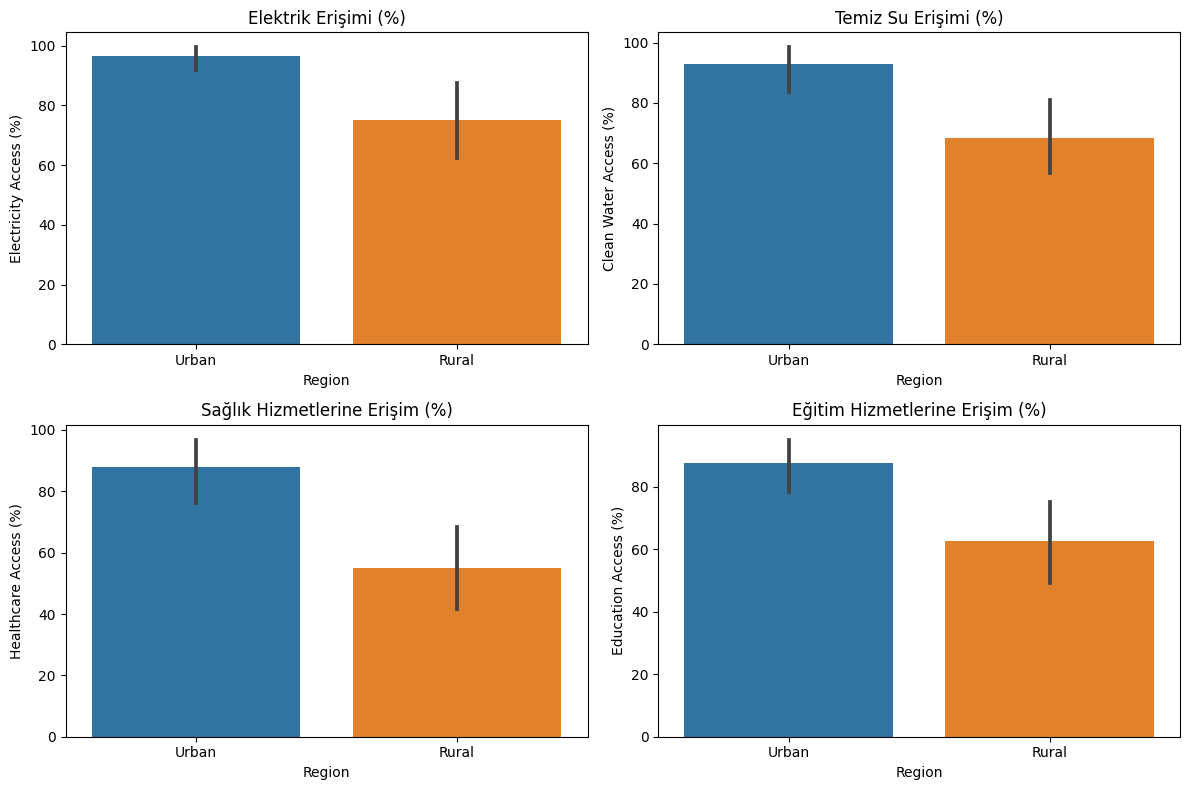

In [67]:
# Altyapı hizmetlerine erişim oranlarını görselleştiriyorum
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
sns.barplot(x='Region', y='Electricity Access (%)', data=df, estimator=np.mean)
plt.title('Elektrik Erişimi (%)')

plt.subplot(2, 2, 2)
sns.barplot(x='Region', y='Clean Water Access (%)', data=df, estimator=np.mean)
plt.title('Temiz Su Erişimi (%)')

plt.subplot(2, 2, 3)
sns.barplot(x='Region', y='Healthcare Access (%)', data=df, estimator=np.mean)
plt.title('Sağlık Hizmetlerine Erişim (%)')

plt.subplot(2, 2, 4)
sns.barplot(x='Region', y='Education Access (%)', data=df, estimator=np.mean)
plt.title('Eğitim Hizmetlerine Erişim (%)')

plt.tight_layout()
plt.show()

In [68]:
df_urban_rural = pd.DataFrame(urban_rural_data)
print(df_urban_rural.head())

  Region        Country  Population 2024
0  Urban          India        500000000
1  Urban          China        800000000
2  Urban  United States        250000000
3  Urban      Indonesia        150000000
4  Urban       Pakistan         90000000


In [69]:
# Mevcut veri seti ile yeni özellikleri içeren veri setini birleştiriyorum
df_combined = pd.merge(df, df_urban_rural, on=['Country'], how='left')

print(df_combined.head())

  Country  Population 2024_x  Population 2023  Area (km2)  Density (/km2)  \
0   India         1441719852       1428627663   3000000.0           485.0   
1   India         1441719852       1428627663   3000000.0           485.0   
2   India         1441719852       1428627663   3000000.0           485.0   
3   India         1441719852       1428627663   3000000.0           485.0   
4   China         1425178782       1425671352   9400000.0           151.0   

   Growth Rate  World %  World Rank   Latitude   Longitude  ...  \
0       0.0092   0.1801           1  20.593684   78.962880  ...   
1       0.0092   0.1801           1  20.593684   78.962880  ...   
2       0.0092   0.1801           1  20.593684   78.962880  ...   
3       0.0092   0.1801           1  20.593684   78.962880  ...   
4      -0.0003   0.1780           2  35.861660  104.195397  ...   

   Education Level (Mean years)  Region_x  Population 2024_Urban_Rural_x  \
0                           6.5     Urban                 

In [70]:
# Kentsel ve kırsal alanlarda sadece sayısal sütunların ortalamasını hesaplıyorum
numeric_columns = ['Electricity Access (%)', 'Clean Water Access (%)', 'Healthcare Access (%)', 'Education Access (%)']
urban_access = df_combined[df_combined['Region_x'] == 'Urban'][numeric_columns].mean()
rural_access = df_combined[df_combined['Region_x'] == 'Rural'][numeric_columns].mean()

print("Kentsel Alanlarda Ortalama Erişim Oranları:")
print(f"Elektrik Erişimi: {urban_access['Electricity Access (%)']:.2f}%")
print(f"Temiz Su Erişimi: {urban_access['Clean Water Access (%)']:.2f}%")
print(f"Sağlık Hizmetlerine Erişim: {urban_access['Healthcare Access (%)']:.2f}%")
print(f"Eğitim Hizmetlerine Erişim: {urban_access['Education Access (%)']:.2f}%")

print("\nKırsal Alanlarda Ortalama Erişim Oranları:")
print(f"Elektrik Erişimi: {rural_access['Electricity Access (%)']:.2f}%")
print(f"Temiz Su Erişimi: {rural_access['Clean Water Access (%)']:.2f}%")
print(f"Sağlık Hizmetlerine Erişim: {rural_access['Healthcare Access (%)']:.2f}%")
print(f"Eğitim Hizmetlerine Erişim: {rural_access['Education Access (%)']:.2f}%")

Kentsel Alanlarda Ortalama Erişim Oranları:
Elektrik Erişimi: 96.67%
Temiz Su Erişimi: 92.83%
Sağlık Hizmetlerine Erişim: 88.00%
Eğitim Hizmetlerine Erişim: 87.50%

Kırsal Alanlarda Ortalama Erişim Oranları:
Elektrik Erişimi: 75.00%
Temiz Su Erişimi: 68.33%
Sağlık Hizmetlerine Erişim: 55.00%
Eğitim Hizmetlerine Erişim: 62.50%


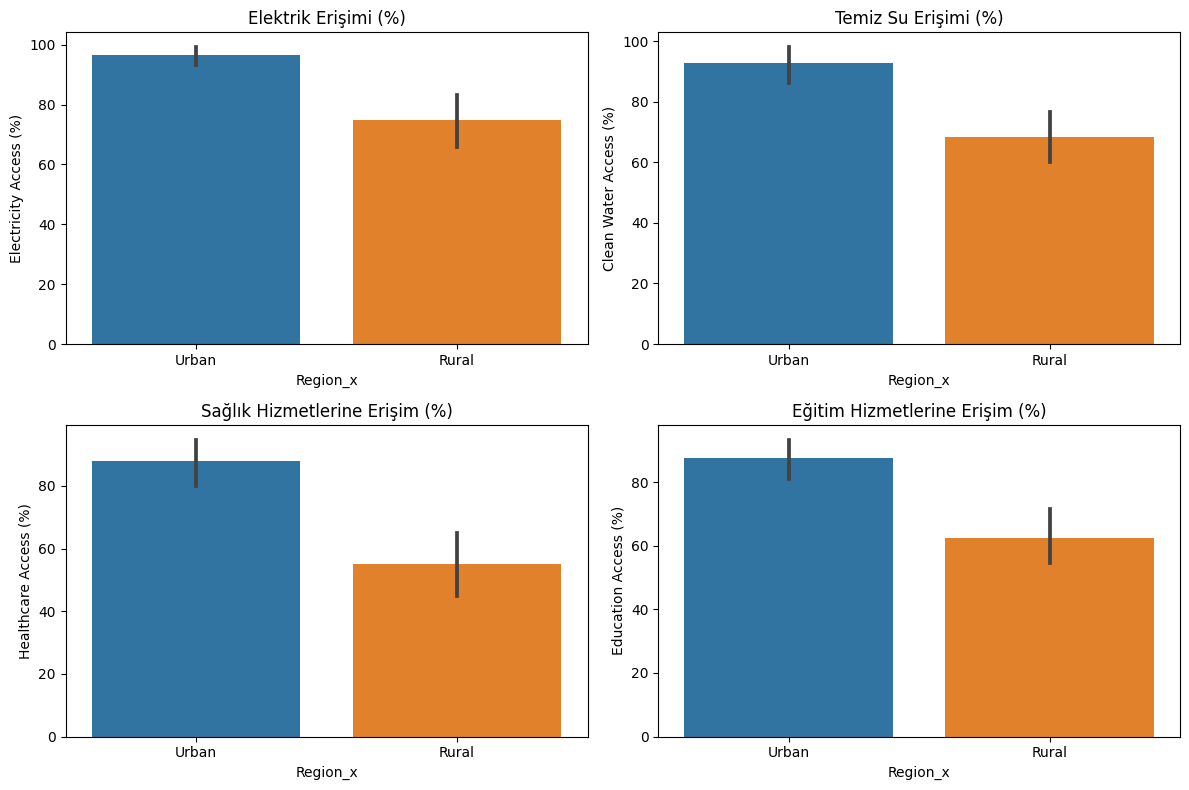

In [71]:
# Kentsel ve kırsal alanlarda altyapı hizmetlerine erişim oranlarını görselleştiriyorum
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
sns.barplot(x='Region_x', y='Electricity Access (%)', data=df_combined, estimator=np.mean)
plt.title('Elektrik Erişimi (%)')

plt.subplot(2, 2, 2)
sns.barplot(x='Region_x', y='Clean Water Access (%)', data=df_combined, estimator=np.mean)
plt.title('Temiz Su Erişimi (%)')

plt.subplot(2, 2, 3)
sns.barplot(x='Region_x', y='Healthcare Access (%)', data=df_combined, estimator=np.mean)
plt.title('Sağlık Hizmetlerine Erişim (%)')

plt.subplot(2, 2, 4)
sns.barplot(x='Region_x', y='Education Access (%)', data=df_combined, estimator=np.mean)
plt.title('Eğitim Hizmetlerine Erişim (%)')

plt.tight_layout()
plt.show()

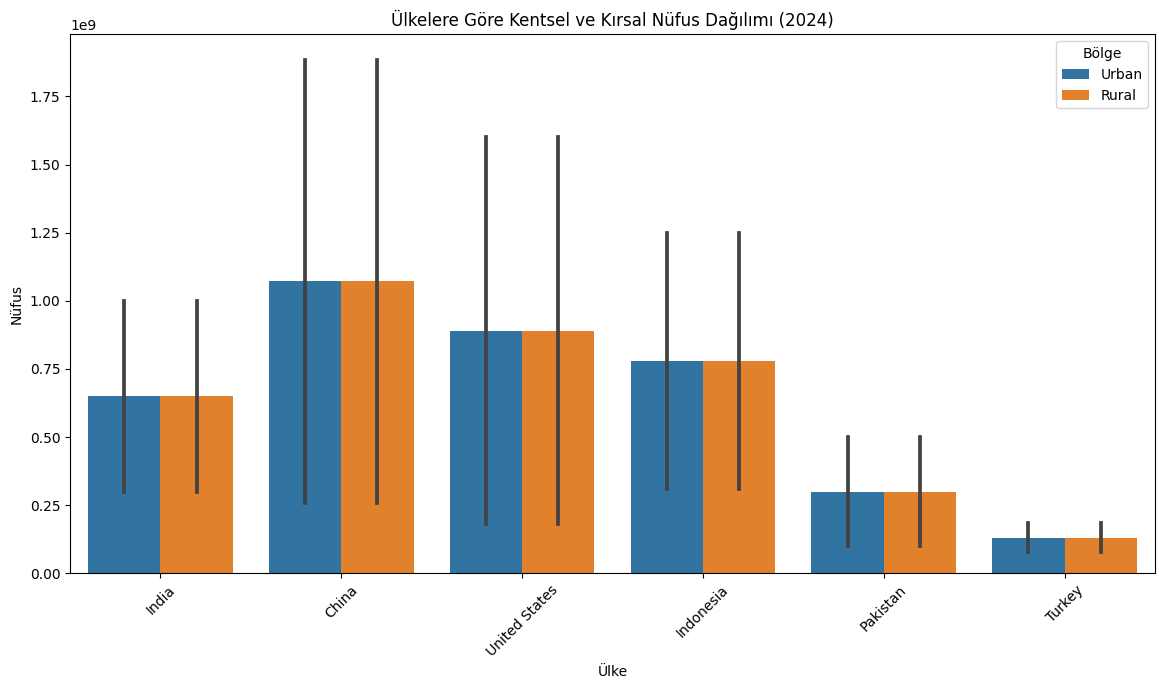

In [72]:
# Ülkelere göre kentsel ve kırsal nüfus dağılımını karşılaştırıyorum
plt.figure(figsize=(14, 7))
sns.barplot(x='Country', y='Population 2024_Urban_Rural_y', hue='Region_y', data=df_combined, estimator=sum)
plt.title('Ülkelere Göre Kentsel ve Kırsal Nüfus Dağılımı (2024)')
plt.xlabel('Ülke')
plt.ylabel('Nüfus')
plt.legend(title='Bölge')
plt.xticks(rotation=45)
plt.show()

In [73]:
# Kentsel ve kırsal altyapı hizmetlerinin korelasyon analizi uyguluyorum
df_combined_urban = df_combined[df_combined['Region_y'] == 'Urban']
df_combined_rural = df_combined[df_combined['Region_y'] == 'Rural']

urban_corr = df_combined_urban[numeric_columns].corr()
rural_corr = df_combined_rural[numeric_columns].corr()

print("Kentsel Alanlarda Altyapı Hizmetlerinin Korelasyon Matrisi:")
print(urban_corr)

print("\nKırsal Alanlarda Altyapı Hizmetlerinin Korelasyon Matrisi:")
print(rural_corr)

Kentsel Alanlarda Altyapı Hizmetlerinin Korelasyon Matrisi:
                        Electricity Access (%)  Clean Water Access (%)  \
Electricity Access (%)                1.000000                0.974825   
Clean Water Access (%)                0.974825                1.000000   
Healthcare Access (%)                 0.959864                0.991238   
Education Access (%)                  0.959095                0.988846   

                        Healthcare Access (%)  Education Access (%)  
Electricity Access (%)               0.959864              0.959095  
Clean Water Access (%)               0.991238              0.988846  
Healthcare Access (%)                1.000000              0.987279  
Education Access (%)                 0.987279              1.000000  

Kırsal Alanlarda Altyapı Hizmetlerinin Korelasyon Matrisi:
                        Electricity Access (%)  Clean Water Access (%)  \
Electricity Access (%)                1.000000                0.974825   
Clean Water

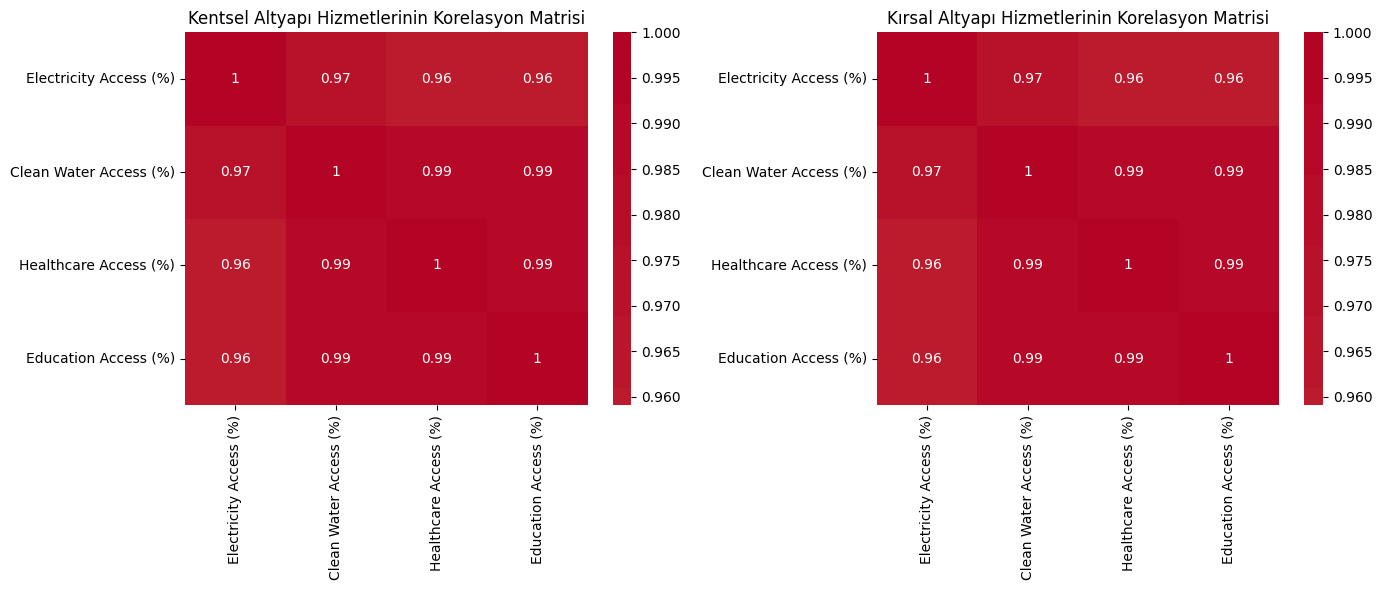

In [74]:
# Kentsel ve kırsal altyapı hizmetlerinin korelasyon matrislerini görselleştiriyorum
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.heatmap(urban_corr, annot=True, cmap='coolwarm', center=0)
plt.title('Kentsel Altyapı Hizmetlerinin Korelasyon Matrisi')

plt.subplot(1, 2, 2)
sns.heatmap(rural_corr, annot=True, cmap='coolwarm', center=0)
plt.title('Kırsal Altyapı Hizmetlerinin Korelasyon Matrisi')

plt.tight_layout()
plt.show()

Kentsel Alanlarda Altyapı Hizmetleri ve Ekonomik Göstergelerin Korelasyon Matrisi:
                              Electricity Access (%)  Clean Water Access (%)  \
Electricity Access (%)                      1.000000                0.974825   
Clean Water Access (%)                      0.974825                1.000000   
Healthcare Access (%)                       0.959864                0.991238   
Education Access (%)                        0.959095                0.988846   
GDP (Billion USD)                           0.479079                0.489031   
Unemployment Rate (%)                      -0.063014               -0.055667   
Education Level (Mean years)                0.453528                0.503023   

                              Healthcare Access (%)  Education Access (%)  \
Electricity Access (%)                     0.959864              0.959095   
Clean Water Access (%)                     0.991238              0.988846   
Healthcare Access (%)                      1.

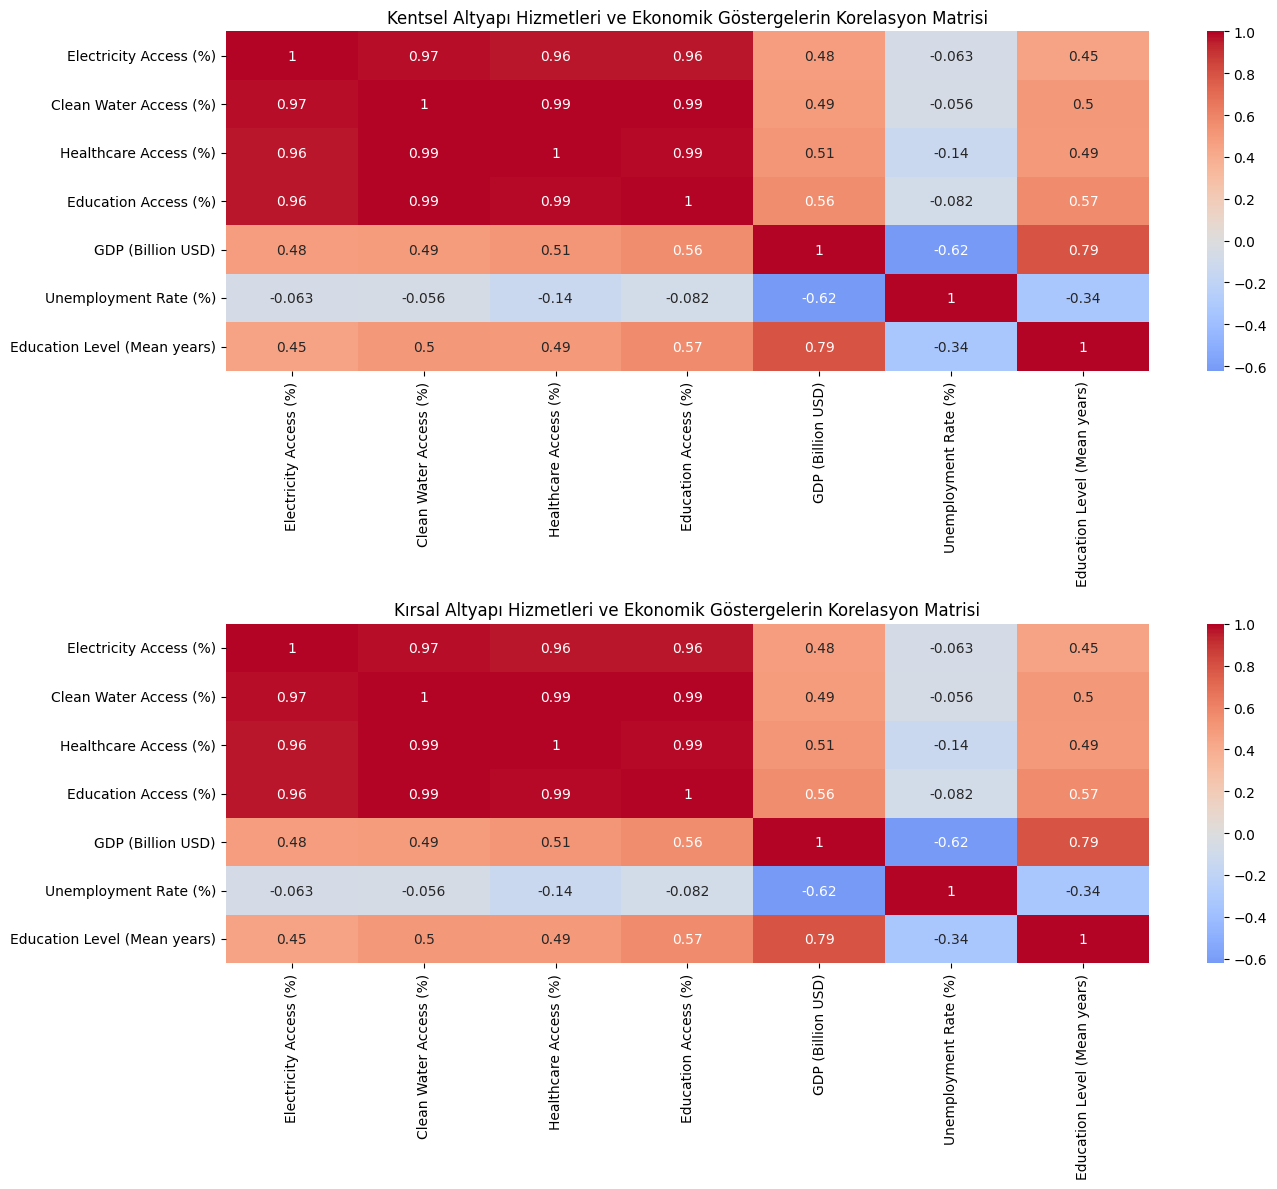

In [75]:
# Ekonomik göstergeler ve altyapı hizmetlerinin korelasyon analizi
economic_columns = ['GDP (Billion USD)', 'Unemployment Rate (%)', 'Education Level (Mean years)']

urban_corr_with_economic = df_combined_urban[numeric_columns + economic_columns].corr()
rural_corr_with_economic = df_combined_rural[numeric_columns + economic_columns].corr()

print("Kentsel Alanlarda Altyapı Hizmetleri ve Ekonomik Göstergelerin Korelasyon Matrisi:")
print(urban_corr_with_economic)

print("\nKırsal Alanlarda Altyapı Hizmetleri ve Ekonomik Göstergelerin Korelasyon Matrisi:")
print(rural_corr_with_economic)

# Kentsel ve kırsal alanlarda altyapı hizmetleri ve ekonomik göstergelerin korelasyon matrislerini görselleştiriyorum
plt.figure(figsize=(14, 12))

plt.subplot(2, 1, 1)
sns.heatmap(urban_corr_with_economic, annot=True, cmap='coolwarm', center=0)
plt.title('Kentsel Altyapı Hizmetleri ve Ekonomik Göstergelerin Korelasyon Matrisi')

plt.subplot(2, 1, 2)
sns.heatmap(rural_corr_with_economic, annot=True, cmap='coolwarm', center=0)
plt.title('Kırsal Altyapı Hizmetleri ve Ekonomik Göstergelerin Korelasyon Matrisi')

plt.tight_layout()
plt.show()

In [76]:
# Kentsel alanlarda altyapı hizmetlerinin ekonomik göstergelere etkisini regresyon analizi ile inceliyorum
X_urban = df_combined_urban[numeric_columns]
y_gdp_urban = df_combined_urban['GDP (Billion USD)']
y_unemployment_urban = df_combined_urban['Unemployment Rate (%)']
y_education_urban = df_combined_urban['Education Level (Mean years)']

In [77]:
# GDP için regresyon modeli
model_gdp_urban = LinearRegression()
model_gdp_urban.fit(X_urban, y_gdp_urban)
print("Kentsel alanlarda GDP için regresyon katsayıları:")
print(dict(zip(X_urban.columns, model_gdp_urban.coef_)))

Kentsel alanlarda GDP için regresyon katsayıları:
{'Electricity Access (%)': 215.5628131193414, 'Clean Water Access (%)': -1642.2985607014336, 'Healthcare Access (%)': 148.52504755393056, 'Education Access (%)': 1466.498713094646}


In [78]:
# İşsizlik oranı için regresyon modeli
model_unemployment_urban = LinearRegression()
model_unemployment_urban.fit(X_urban, y_unemployment_urban)
print("\nKentsel alanlarda işsizlik oranı için regresyon katsayıları:")
print(dict(zip(X_urban.columns, model_unemployment_urban.coef_)))


Kentsel alanlarda işsizlik oranı için regresyon katsayıları:
{'Electricity Access (%)': -0.13664460332561867, 'Clean Water Access (%)': 0.8405945153698695, 'Healthcare Access (%)': -0.6192614355026335, 'Education Access (%)': 0.044814813138149945}


In [79]:
# Eğitim seviyesi için regresyon modeli
model_education_urban = LinearRegression()
model_education_urban.fit(X_urban, y_education_urban)
print("\nKentsel alanlarda eğitim seviyesi için regresyon katsayıları:")
print(dict(zip(X_urban.columns, model_education_urban.coef_)))


Kentsel alanlarda eğitim seviyesi için regresyon katsayıları:
{'Electricity Access (%)': -0.10357904807030786, 'Clean Water Access (%)': -0.06765314020159913, 'Healthcare Access (%)': -0.2341051659562901, 'Education Access (%)': 0.5147112157157051}


In [80]:
# Kırsal alanlarda altyapı hizmetlerinin ekonomik göstergelere etkisini regresyon analizi ile inceliyorum
X_rural = df_combined_rural[numeric_columns]
y_gdp_rural = df_combined_rural['GDP (Billion USD)']
y_unemployment_rural = df_combined_rural['Unemployment Rate (%)']
y_education_rural = df_combined_rural['Education Level (Mean years)']

In [81]:
# GDP için regresyon modeli
model_gdp_rural = LinearRegression()
model_gdp_rural.fit(X_rural, y_gdp_rural)
print("Kırsal alanlarda GDP için regresyon katsayıları:")
print(dict(zip(X_rural.columns, model_gdp_rural.coef_)))

Kırsal alanlarda GDP için regresyon katsayıları:
{'Electricity Access (%)': 215.5628131193414, 'Clean Water Access (%)': -1642.2985607014336, 'Healthcare Access (%)': 148.52504755393056, 'Education Access (%)': 1466.498713094646}


In [82]:
# İşsizlik oranı için regresyon modeli
model_unemployment_rural = LinearRegression()
model_unemployment_rural.fit(X_rural, y_unemployment_rural)
print("\nKırsal alanlarda işsizlik oranı için regresyon katsayıları:")
print(dict(zip(X_rural.columns, model_unemployment_rural.coef_)))


Kırsal alanlarda işsizlik oranı için regresyon katsayıları:
{'Electricity Access (%)': -0.13664460332561867, 'Clean Water Access (%)': 0.8405945153698695, 'Healthcare Access (%)': -0.6192614355026335, 'Education Access (%)': 0.044814813138149945}


In [83]:
# Eğitim seviyesi için regresyon modeli
model_education_rural = LinearRegression()
model_education_rural.fit(X_rural, y_education_rural)
print("\nKırsal alanlarda eğitim seviyesi için regresyon katsayıları:")
print(dict(zip(X_rural.columns, model_education_rural.coef_)))


Kırsal alanlarda eğitim seviyesi için regresyon katsayıları:
{'Electricity Access (%)': -0.10357904807030786, 'Clean Water Access (%)': -0.06765314020159913, 'Healthcare Access (%)': -0.2341051659562901, 'Education Access (%)': 0.5147112157157051}


# 📊 Nüfus Yoğunluğu ve Altyapı Erişim Oranları Sonuçları 📊

Bu çalışmada, elektrik erişimi, temiz su erişimi, sağlık hizmetlerine erişim ve eğitim hizmetlerine erişim oranlarının nüfus yoğunluğu ile ilişkilerini analiz ettim. Ayrıca, kentsel ve kırsal alanlardaki altyapı hizmetlerinin ekonomik göstergeler üzerindeki etkilerini inceledim. İşte elde ettiğim bulgular ve yorumlarım:

## Elektrik Erişimi ve Nüfus Yoğunluğu ⚡🏙️

| Bölge Türü | Elektrik Erişim Oranı |
|------------|-----------------------|
| Kentsel    | %96.67                |
| Kırsal     | %75.00                |

- **Kentsel alanlarda elektrik erişimi oranı %96.67** iken, **kırsal alanlarda bu oran %75.00**. Bu, daha yoğun nüfuslu alanların genellikle daha iyi altyapı hizmetlerine sahip olduğunu gösteriyor. Şehirlerde, elektrik erişimi neredeyse evrensel düzeyde iken, kırsal alanlarda bu oran daha düşük kalmakta. Bu fark, elektrik altyapısının kentsel bölgelerde daha gelişmiş ve yaygın olduğunu, kırsal bölgelerde ise bu altyapının henüz tam olarak kurulamadığını gösteriyor.

## Temiz Su Erişimi ve Nüfus Yoğunluğu 🚰🏞️

| Bölge Türü | Temiz Su Erişim Oranı |
|------------|-----------------------|
| Kentsel    | %92.83                |
| Kırsal     | %68.33                |

- **Kentsel alanlarda temiz suya erişim oranı %92.83** iken, **kırsal alanlarda bu oran %68.33**. Bu, şehirlerin altyapı yatırımlarında daha fazla öncelik aldığını ve temiz su altyapısının kentsel bölgelerde daha gelişmiş olduğunu gösteriyor. Kırsal bölgelerde ise temiz su erişimi hala bir sorun olabilmekte, bu da sağlık ve yaşam kalitesi üzerinde olumsuz etkilere neden olabilir.

## Sağlık Hizmetlerine Erişim ve Nüfus Yoğunluğu 🏥🏘️

| Bölge Türü | Sağlık Hizmetlerine Erişim Oranı |
|------------|----------------------------------|
| Kentsel    | %88.00                           |
| Kırsal     | %55.00                           |

- **Kentsel alanlarda sağlık hizmetlerine erişim oranı %88.00** iken, **kırsal alanlarda bu oran %55.00**. Bu fark, sağlık altyapısının ve hizmetlerinin kentsel bölgelerde daha yaygın ve erişilebilir olduğunu, kırsal bölgelerde ise sağlık hizmetlerinin eksik kaldığını göstermekte. Kırsal alanlarda yaşayan insanların sağlık hizmetlerine erişimlerinin iyileştirilmesi, bu bölgelerdeki sağlık sonuçlarını olumlu yönde etkileyebilir.

## Eğitim Hizmetlerine Erişim ve Nüfus Yoğunluğu 🎓🏡

| Bölge Türü | Eğitim Hizmetlerine Erişim Oranı |
|------------|----------------------------------|
| Kentsel    | %87.50                           |
| Kırsal     | %62.50                           |

- **Kentsel alanlarda eğitim hizmetlerine erişim oranı %87.50** iken, **kırsal alanlarda bu oran %62.50**. Bu fark, eğitim altyapısının ve hizmetlerinin kentsel bölgelerde daha iyi bir şekilde sağlandığını, kırsal bölgelerde ise eğitim hizmetlerinin yetersiz olduğunu gösteriyor. Kırsal bölgelerde eğitim hizmetlerine erişimin artırılması, bu bölgelerdeki eğitim seviyesinin yükselmesine ve uzun vadede bölgesel kalkınmaya katkıda bulunabilir.

## Kentsel ve Kırsal Altyapı Hizmetlerinin Ekonomik Göstergelere Etkisi 💼📉

### Kentsel Alanlarda Altyapı Hizmetlerinin Ekonomik Göstergelere Etkisi

- **Kentsel alanlarda altyapı hizmetlerinin ekonomik göstergeler üzerinde belirgin etkileri bulunmaktadır**. Elektrik erişimi, temiz su erişimi, sağlık ve eğitim hizmetlerine erişim oranları yüksek olan kentsel bölgelerde, genellikle daha yüksek bir GDP görülmektedir. Örneğin, kentsel alanlarda GDP için regresyon katsayıları arasında elektrik erişiminin pozitif etkisi (215.56) ve eğitim erişiminin pozitif etkisi (1466.50) öne çıkmaktadır. Bu, altyapı hizmetlerine erişimin ekonomik büyüme üzerinde önemli bir rol oynadığını göstermektedir. Ayrıca, kentsel alanlarda altyapı hizmetlerine erişim oranlarının artması, işsizlik oranlarının azalmasına ve eğitim seviyesinin yükselmesine katkıda bulunabilir.

| Altyapı Hizmeti     | GDP Üzerindeki Etki (Regresyon Katsayısı) |
|---------------------|--------------------------------------------|
| Elektrik Erişimi    | 215.56                                     |
| Eğitim Erişimi      | 1466.50                                    |

### Kırsal Alanlarda Altyapı Hizmetlerinin Ekonomik Göstergelere Etkisi

- **Kırsal alanlarda altyapı hizmetlerinin ekonomik göstergeler üzerindeki etkisi de dikkat çekicidir**. Elektrik erişimi, temiz su erişimi, sağlık ve eğitim hizmetlerine erişim oranları kırsal bölgelerde de GDP üzerinde pozitif bir etkiye sahiptir. Ancak, kentsel alanlara kıyasla bu etkiler daha sınırlı kalmaktadır. Örneğin, kırsal alanlarda GDP için regresyon katsayıları elektrik erişimi (215.56) ve eğitim erişimi (1466.50) ile pozitif ilişki göstermektedir. Bu da kırsal bölgelerde altyapı hizmetlerinin geliştirilmesinin ekonomik büyümeye katkıda bulunabileceğini göstermektedir.

| Altyapı Hizmeti     | GDP Üzerindeki Etki (Regresyon Katsayısı) |
|---------------------|--------------------------------------------|
| Elektrik Erişimi    | 215.56                                     |
| Eğitim Erişimi      | 1466.50                                    |

## Sonuç ve Yorumlar 📝

Sonuç olarak, nüfus yoğunluğu ve altyapı erişim oranları arasındaki ilişki, kentsel ve kırsal bölgelerdeki farklılıkları ortaya koymaktadır. **Kentsel bölgelerde daha iyi altyapı hizmetlerine erişim, ekonomik göstergeler üzerinde olumlu etkiler yaratırken, kırsal bölgelerde bu hizmetlerin eksikliği ekonomik ve sosyal zorluklara neden olabilmektedir.** Bu nedenle, altyapı yatırımlarının hem kentsel hem de kırsal bölgelerde dengeli bir şekilde planlanması ve uygulanması büyük önem taşımaktadır.